In [1]:
# this is just a jupyter things
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
# import basic library
import json
import os
import random
import time

In [20]:
# import deep learning related
import torch
import torchaudio

### Audio-Spectogram parser and Spectogram dataset module

In [21]:
import math
from tempfile import NamedTemporaryFile
import librosa
import numpy as np
import scipy.signal
import soundfile as sf
import sox
from torch.utils.data import Dataset, Sampler, DataLoader

windows = {
    'hamming': scipy.signal.hamming,
    'hann': scipy.signal.hann,
    'blackman': scipy.signal.blackman,
    'bartlett': scipy.signal.bartlett
}

In [22]:
class AudioParser(object):
    def parse_transcript(self, transcript_path):
        raise NotImplementedError

    def parse_audio(self, audio_path):
        raise NotImplementedError

In [23]:
class SpectrogramParser(AudioParser):
    def __init__(self, audio_conf):
        super(SpectrogramParser, self).__init__()
        self.window_stride = audio_conf['window_stride']
        self.window_size = audio_conf['window_size']
        self.sample_rate = audio_conf['sample_rate']
        self.window = windows.get(audio_conf['window'], windows['hamming'])

    def parse_audio(self, audio_path):
        y = load_audio(audio_path)
        n_fft = int(self.sample_rate * self.window_size)
        win_length = n_fft
        hop_length = int(self.sample_rate * self.window_stride)

        # STFT
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=self.window)
        spect, phase = librosa.magphase(D)
        # S = log(S+1)
        spect = np.log1p(spect)
        spect = torch.FloatTensor(spect)
        
        #normalized version
#         mean = spect.mean()
#         std = spect.std()
#         spect.add_(-mean)
#         spect.div_(std)

        return spect

    def parse_transcript(self, transcript_path):
        raise NotImplementedError

In [24]:
# load audio
from scipy.io.wavfile import read
import librosa
import librosa.display # need this for ver 0.5.0+
import numpy as np
import matplotlib.pyplot as plt

def load_audio(path):

    try:
        sample_rate, sound = read(path)
    except:
        print("path: ", path)
    
    sound = sound.astype('float32') / 32767  # normalize audio
    if len(sound.shape) > 1:
        if sound.shape[1] == 1:
            sound = sound.squeeze()
        else:
            sound = sound.mean(axis=1)  # multiple channels, average
    return sound

# parse audio 

sample_rate = 16000
window_size = .02
window_stride = .01
window = 'hamming'
# window = 'hann'

In [25]:
class SpectrogramDataset(Dataset, SpectrogramParser):
    def __init__(self, audio_conf, manifest_filepath, labels):
        ids = self._parse_input(manifest_filepath)
        self.ids = ids
        self.size = len(ids)
        self.labels_map = dict([(labels[i], i) for i in range(len(labels))])
        super(SpectrogramDataset, self).__init__(audio_conf)

    def _parse_input(self, input_path):
        ids = []
        if os.path.isdir(input_path):
            for wav_path in Path(input_path).rglob('*.wav'):
                transcript_path = str(wav_path).replace('/wav/', '/txt/').replace('.wav', '.txt')
                ids.append((wav_path, transcript_path))
        else:
            with open(input_path) as f:
                manifest = json.load(f)
                for sample in manifest['samples']:
                    wav_path = os.path.join(manifest['root_path'], sample['wav_path'])
                    transcript_path = os.path.join(manifest['root_path'], sample['transcript_path'])
                    ids.append((wav_path, transcript_path))
        return ids
    
    def __getitem__(self, index):
        sample = self.ids[index]
        audio_path, transcript_path = sample[0], sample[1]
        spect = self.parse_audio(audio_path)
        transcript = self.parse_transcript(transcript_path)
        return spect, transcript
    
    def parse_transcript(self, transcript_path):
        with open(transcript_path, 'r', encoding='utf8') as transcript_file:
            transcript = transcript_file.read().replace('\n', '')
        transcript = list(filter(None, [self.labels_map.get(x) for x in list(transcript)]))
        return transcript

    def __len__(self):
        return self.size

In [26]:
class DSRandomSampler(Sampler):

    def __init__(self, dataset, batch_size=1, start_index=0):
        super().__init__(data_source=dataset)

        self.dataset = dataset
        self.start_index = start_index
        self.batch_size = batch_size
        ids = list(range(len(self.dataset)))
        self.bins = [ids[i:i + self.batch_size] for i in range(0, len(ids), self.batch_size)]

    def __iter__(self):
        # deterministically shuffle based on epoch
        g = torch.Generator()
        g.manual_seed(self.epoch)
        indices = (
            torch.randperm(len(self.bins) - self.start_index, generator=g)
                .add(self.start_index)
                .tolist()
        )
        for x in indices:
            batch_ids = self.bins[x]
            np.random.shuffle(batch_ids)
            yield batch_ids

    def __len__(self):
        return len(self.bins) - self.start_index

    def set_epoch(self, epoch):
        self.epoch = epoch

    def reset_training_step(self, training_step):
        self.start_index = training_step

In [27]:
raw_inputs= []

def _collate_fn(batch):

    def func(p):
        return p[0].size(1)

    batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)
    longest_sample = max(batch, key=func)[0]
    freq_size = longest_sample.size(0)
    minibatch_size = len(batch)
    max_seqlength = longest_sample.size(1)
    
    inputs = torch.zeros(minibatch_size, 1, freq_size, max_seqlength)
    input_percentages = torch.FloatTensor(minibatch_size)
    target_sizes = torch.IntTensor(minibatch_size)
    targets = []
    for x in range(minibatch_size):
        sample = batch[x]
        tensor = sample[0]
        target = sample[1]
        seq_length = tensor.size(1)
        inputs[x][0].narrow(1, 0, seq_length).copy_(tensor)
        input_percentages[x] = seq_length / float(max_seqlength)
        target_sizes[x] = len(target)
        targets.extend(target)
    targets = torch.IntTensor(targets)
    return inputs, targets, input_percentages, target_sizes

In [28]:
class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn
        

In [29]:
# audio conf
audio_conf = dict(sample_rate=16000,
                  window_size=.02,
                  window_stride=.01,
                  window='hamming')


# labels to map token to index
labels = [
    '_',
    '!',
 '"',
 "'",
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '?',
 '।',
 '॥',
 'ঁ',
 'ং',
 'ঃ',
 'অ',
 'আ',
 'ই',
 'ঈ',
 'উ',
 'ঊ',
 'ঋ',
 'এ',
 'ঐ',
 'ও',
 'ঔ',
 'ক',
 'খ',
 'গ',
 'ঘ',
 'ঙ',
 'চ',
 'ছ',
 'জ',
 'ঝ',
 'ঞ',
 'ট',
 'ঠ',
 'ড',
 'ঢ',
 'ণ',
 'ত',
 'থ',
 'দ',
 'ধ',
 'ন',
 'প',
 'ফ',
 'ব',
 'ভ',
 'ম',
 'য',
 'র',
 'ল',
 'শ',
 'ষ',
 'স',
 'হ',
 '়',
 'া',
 'ি',
 'ী',
 'ু',
 'ূ',
 'ৃ',
 'ে',
 'ৈ',
 'ো',
 'ৌ',
 '্',
 'ৎ',
 'ৗ',
 'ড়',
 'ঢ়',
 'য়',
 'ৰ',
 '৵',
 '৷',
 '–',
 '—',
 '‘',
 '’',
 '‚',
 '“',
 '”',
 '…',
 ' ',
  ]

In [30]:
len(labels)

88

In [31]:
# manifest_txt = "/content/manifest.txt"
manifest_json = "./data2/train/manifest.json"
valid_manifest_json = "./data2/valid/manifest.json"
training_data = SpectrogramDataset(audio_conf, manifest_json, labels)
valid_data = SpectrogramDataset(audio_conf, valid_manifest_json, labels)

In [32]:
# sampler to use bins
train_sampler = DSRandomSampler(dataset=training_data,
                                batch_size=5,
                                start_index=0)
# valid_sampler = DSRandomSampler(dataset=valid_data,
#                                 batch_size=5,
#                                 start_index=0)

In [33]:
train_loader = AudioDataLoader(dataset=training_data,
                               num_workers=1,
                               batch_sampler=train_sampler)

valid_loader = AudioDataLoader(dataset=valid_data,
                               num_workers=1,
                               batch_size=5)

In [17]:
# data = next(train_loader)
# data

In [34]:
labels_map = dict([(labels[i], i) for i in range(len(labels))])
def parse_transcript(transcript_path):
    with open(transcript_path, 'r', encoding='utf8') as transcript_file:
        transcript = transcript_file.read().replace('\n', '')
    transcript = list(filter(None, [labels_map.get(x) for x in list(transcript)]))
    return transcript

In [123]:
# transcript = parse_transcript("common_voice_bn_31741347.txt")

In [124]:
# epoch = args.epochs
# state.set_epoch(epoch=epoch)
# train_sampler.set_epoch(epoch=epoch)
# train_sampler.reset_training_step(training_step=state.training_step)
# # idx, (data)  = enumerate(train_loader, start=state.training_step)
# state.set_training_step(training_step=1)
# inputs, targets, input_percentages, target_sizes = train_loader

In [20]:
# use TrainingState to track training state
state = TrainingState(model=model)
state.init_results_tracking(epochs=args.epochs)
criterion = nn.CTCLoss(blank=labels.index('_'), zero_infinity=False)

NameError: name 'TrainingState' is not defined

In [137]:
epoch = args.epochs
saved_inps = []
saved_inpercentage = []
state.set_epoch(epoch=epoch)
train_sampler.set_epoch(epoch=epoch)
train_sampler.reset_training_step(training_step=state.training_step)
for idx, (data) in enumerate(train_loader, start=state.training_step):
    state.set_training_step(training_step=idx)
    inputs, targets, input_percentages, target_sizes = data
#     print(f'Batch shape {inputs.shape}')
    saved_inps.append(inputs)
    saved_inpercentage.append(input_percentages)
    input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
    # measure data loading time
#     data_time.update(time.time())
    inputs = inputs.to(device)

In [138]:
epoch = args.epochs
saved_inps = []
saved_inpercentage = []
state.set_epoch(epoch=epoch)
# test_sampler.set_epoch(epoch=epoch)
# test_sampler.reset_training_step(training_step=state.training_step)
for idx, (data) in enumerate(valid_loader, len(valid_loader)):
    state.set_training_step(training_step=idx)
    inputs, targets, input_percentages, target_sizes = data
    saved_inps.append(inputs)
    saved_inpercentage.append(input_percentages)
    input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
    # measure data loading time
    data_time.update(time.time())
    inputs = inputs.to(device)

In [ ]:
len(valid_loader)

In [ ]:
saved_inps[0] = saved_inps[0].to(device)

In [129]:
target_sizes

tensor([114, 113,  87,  26,  33], dtype=torch.int32)

In [130]:
targets.size()

torch.Size([373])

In [135]:
out, output_sizes = model(inputs, input_percentages)
out = out.transpose(0, 1)  # TxNxH
out.shape

torch.Size([458, 5, 88])

In [136]:
output_sizes

tensor([458, 436, 271, 170,  44], dtype=torch.int32)

In [200]:
float_out = out.float()  # ensure float32 for loss
loss = criterion(float_out, targets, output_sizes, target_sizes).to(device)
loss

tensor(14.1523, device='cuda:0', grad_fn=<MeanBackward0>)

In [201]:
loss = loss / inputs.size(0)  # average the loss by minibatch
loss_value = loss.item()

In [202]:
valid_loss, error = check_loss(loss, loss_value)

In [204]:
loss

True

In [14]:
import Levenshtein as Lev
import torch
from six.moves import xrange

class Decoder(object):

    def __init__(self, labels, blank_index=0):
        self.labels = labels
        self.int_to_char = dict([(i, c) for (i, c) in enumerate(labels)])
        self.blank_index = blank_index
        space_index = len(labels)  # To prevent errors in decode, we add an out of bounds index for the space
        if ' ' in labels:
            space_index = labels.index(' ')
        self.space_index = space_index

    def wer(self, s1, s2):

        # build mapping of words to integers
        b = set(s1.split() + s2.split())
        word2char = dict(zip(b, range(len(b))))

        # map the words to a char array (Levenshtein packages only accepts
        # strings)
        w1 = [chr(word2char[w]) for w in s1.split()]
        w2 = [chr(word2char[w]) for w in s2.split()]

        return Lev.distance(''.join(w1), ''.join(w2))

    def cer(self, s1, s2):
     
        s1, s2, = s1.replace(' ', ''), s2.replace(' ', '')
        return Lev.distance(s1, s2)

    def decode(self, probs, sizes=None):
       
        raise NotImplementedError

        
        
        
        
        
class GreedyDecoder(Decoder):
    def __init__(self, labels, blank_index=0):
        super(GreedyDecoder, self).__init__(labels, blank_index)

    def convert_to_strings(self, sequences, sizes=None, remove_repetitions=False, return_offsets=False):
        strings = []
        offsets = [] if return_offsets else None
        for x in xrange(len(sequences)):
            seq_len = sizes[x] if sizes is not None else len(sequences[x])
            string, string_offsets = self.process_string(sequences[x], seq_len, remove_repetitions)
            strings.append([string])  # We only return one path
            if return_offsets:
                offsets.append([string_offsets])
        if return_offsets:
            return strings, offsets
        else:
            return strings

    def process_string(self, sequence, size, remove_repetitions=False):
        string = ''
        offsets = []
        for i in range(size):
            char = self.int_to_char[sequence[i].item()]
            if char != self.int_to_char[self.blank_index]:
                # if this char is a repetition and remove_repetitions=true, then skip
                if remove_repetitions and i != 0 and char == self.int_to_char[sequence[i - 1].item()]:
                    pass
                elif char == self.labels[self.space_index]:
                    string += ' '
                    offsets.append(i)
                else:
                    string = string + char
                    offsets.append(i)
        return string, torch.tensor(offsets, dtype=torch.int)

    def decode(self, probs, sizes=None):
       
        _, max_probs = torch.max(probs, 2)
        strings, offsets = self.convert_to_strings(max_probs.view(max_probs.size(0), max_probs.size(1)), sizes,
                                                   remove_repetitions=True, return_offsets=True)
        return strings, offsets

Define DeepSpeech, and supported_rnns
This is equivalent of from model import DeepSpeech, supported_rnns

In [11]:
import math
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
class InferenceBatchSoftmax(nn.Module):
    def forward(self, input_):
        if not self.training:
            return F.softmax(input_, dim=-1)
        else:
            return input_
#             return F.log_softmax(input_, -1)
        
class BatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, batch_norm=True):
        super(BatchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size)) if batch_norm else None
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size,
                            bidirectional=bidirectional, bias=True)
        self.num_directions = 2 if bidirectional else 1

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x, output_lengths):
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = nn.utils.rnn.pack_padded_sequence(x, output_lengths)
        x, h = self.rnn(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)
        if self.bidirectional:
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)  # (TxNxH*2) -> (TxNxH) by sum
        return x
    
class SequenceWise(nn.Module):
    def __init__(self, module):
        
        super(SequenceWise, self).__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        tmpstr += self.module.__repr__()
        tmpstr += ')'
        return tmpstr
    
class MaskConv(nn.Module):
    def __init__(self, seq_module):
        
        super(MaskConv, self).__init__()
        self.seq_module = seq_module

    def forward(self, x, lengths):
        
        for module in self.seq_module:
            x = module(x)
            mask = torch.BoolTensor(x.size()).fill_(0)
            if x.is_cuda:
                mask = mask.cuda()
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths
    
    
class DeepSpeech(nn.Module):
    def __init__(self, rnn_type, labels, rnn_hidden_size, nb_layers, audio_conf,
                 bidirectional, context=20):
        super(DeepSpeech, self).__init__()

        self.hidden_size = rnn_hidden_size
        self.hidden_layers = nb_layers
        self.rnn_type = rnn_type
        self.audio_conf = audio_conf
        self.labels = labels
        self.bidirectional = bidirectional

        sample_rate = self.audio_conf["sample_rate"]
        window_size = self.audio_conf["window_size"]
        num_classes = len(self.labels)

        self.conv = MaskConv(nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        ))
        # Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
        rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
        rnn_input_size *= 32

        rnns = []
        rnn = BatchRNN(input_size=rnn_input_size, hidden_size=rnn_hidden_size, rnn_type=rnn_type,
                       bidirectional=bidirectional, batch_norm=False)
        rnns.append(('0', rnn))
        for x in range(nb_layers - 1):
            rnn = BatchRNN(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, rnn_type=rnn_type,
                           bidirectional=bidirectional)
            rnns.append(('%d' % (x + 1), rnn))
        self.rnns = nn.Sequential(OrderedDict(rnns))
        self.lookahead = nn.Sequential(
            # consider adding batch norm?
            Lookahead(rnn_hidden_size, context=context),
            nn.Hardtanh(0, 20, inplace=True)
        ) if not bidirectional else None

        fully_connected = nn.Sequential(
            nn.BatchNorm1d(rnn_hidden_size),
            nn.Linear(rnn_hidden_size, num_classes, bias=False)
        )
        self.fc = nn.Sequential(
            SequenceWise(fully_connected),
        )
        self.inference_softmax = InferenceBatchSoftmax()

    def forward(self, x, lengths):
        lengths = lengths.cpu().int()
        output_lengths = self.get_seq_lens(lengths)
        x, _ = self.conv(x, output_lengths)

        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
        x = x.transpose(1, 2).transpose(0, 1).contiguous()  # TxNxH

        for rnn in self.rnns:
            x = rnn(x, output_lengths)

        if not self.bidirectional:  # no need for lookahead layer in bidirectional
            x = self.lookahead(x)

        x = self.fc(x)
        x = x.transpose(0, 1)
        # identity in training mode, softmax in eval mode
        x = self.inference_softmax(x)
        return x, output_lengths

    def get_seq_lens(self, input_length):
        """
        Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
        containing the size sequences that will be output by the network.
        :param input_length: 1D Tensor
        :return: 1D Tensor scaled by model
        """
        seq_len = input_length
        for m in self.conv.modules():
            if type(m) == nn.modules.conv.Conv2d:
                seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) / m.stride[1] + 1)
#         print(seq_len.int(), "  " , input_length)
        return seq_len.int()

    @classmethod
    def load_model(cls, path):
        package = torch.load(path, map_location=lambda storage, loc: storage)
        model = DeepSpeech.load_model_package(package)
        return model

    @classmethod
    def load_model_package(cls, package):
        model = cls(rnn_hidden_size=package['hidden_size'],
                    nb_layers=package['hidden_layers'],
                    labels=package['labels'],
                    audio_conf=package['audio_conf'],
                    rnn_type=supported_rnns[package['rnn_type']],
                    bidirectional=package.get('bidirectional', True))
        model.load_state_dict(package['state_dict'])
        return model

    def serialize_state(self):
        return {
            'hidden_size': self.hidden_size,
            'hidden_layers': self.hidden_layers,
            'rnn_type': supported_rnns_inv.get(self.rnn_type, self.rnn_type.__name__.lower()),
            'audio_conf': self.audio_conf,
            'labels': self.labels,
            'state_dict': self.state_dict(),
            'bidirectional': self.bidirectional,
        }

    @staticmethod
    def get_param_size(model):
        params = 0
        for p in model.parameters():
            tmp = 1
            for x in p.size():
                tmp *= x
            params += tmp
        return params
supported_rnns = {
    'lstm': nn.LSTM,
    'rnn': nn.RNN,
    'gru': nn.GRU
}
supported_rnns_inv = dict((v, k) for k, v in supported_rnns.items())
 

Define TrainingState


this is equivalent of from state import TrainingState

In [27]:
import torch
def remove_parallel_wrapper(model):
    
    # Take care of distributed/data-parallel wrapper
    model_no_wrapper = model.module if hasattr(model, "module") else model
    return model_no_wrapper
class ResultState:
    def __init__(self,
                 loss_results,
                 wer_results,
                 cer_results):
        self.loss_results = loss_results
        self.wer_results = wer_results
        self.cer_results = cer_results

    def add_results(self,
                    epoch,
                    loss_result,
                    wer_result,
                    cer_result):
        self.loss_results[epoch] = loss_result
        self.wer_results[epoch] = wer_result
        self.cer_results[epoch] = cer_result

    def serialize_state(self):
        return {
            'loss_results': self.loss_results,
            'wer_results': self.wer_results,
            'cer_results': self.cer_results
        }

In [28]:
class TrainingState:
    def __init__(self,
                 model,
                 result_state=None,
                 optim_state=None,
                 amp_state=None,
                 best_wer=None,
                 avg_loss=0,
                 epoch=0,
                 training_step=0):
      
        self.model = model
        self.result_state = result_state
        self.optim_state = optim_state
        self.amp_state = amp_state
        self.best_wer = best_wer
        self.avg_loss = avg_loss
        self.epoch = epoch
        self.training_step = training_step

    def track_optim_state(self, optimizer):
        self.optim_state = optimizer.state_dict()

    def track_amp_state(self, amp):
        self.amp_state = amp.state_dict()

    def init_results_tracking(self, epochs):
        self.result_state = ResultState(loss_results=torch.IntTensor(epochs),
                                        wer_results=torch.IntTensor(epochs),
                                        cer_results=torch.IntTensor(epochs))

    def add_results(self,
                    epoch,
                    loss_result,
                    wer_result,
                    cer_result):
        self.result_state.add_results(epoch=epoch,
                                      loss_result=loss_result,
                                      wer_result=wer_result,
                                      cer_result=cer_result)

    def init_finetune_states(self, epochs):
       
        self.init_results_tracking(epochs)
        self._reset_amp_state()
        self._reset_optim_state()
        self._reset_epoch()
        self.reset_training_step()
        self._reset_best_wer()

    def serialize_state(self, epoch, iteration):
        model = remove_parallel_wrapper(self.model)
        model_dict = model.serialize_state()
        training_dict = self._serialize_training_state(epoch=epoch,
                                                       iteration=iteration)
        results_dict = self.result_state.serialize_state()
        # Ensure flat structure for backwards compatibility
        state_dict = {**model_dict, **training_dict, **results_dict}  # Combine dicts
        return state_dict

    def _serialize_training_state(self, epoch, iteration):
        return {
            'optim_dict': self.optim_state,
            'amp': self.amp_state,
            'avg_loss': self.avg_loss,
            'best_wer': self.best_wer,
            'epoch': epoch + 1,  # increment for readability
            'iteration': iteration,
        }

    @classmethod
    def load_state(cls, state_path):
        print("Loading state from model %s" % state_path)
        state = torch.load(state_path, map_location=lambda storage, loc: storage)
        model = DeepSpeech.load_model_package(state)
        optim_state = state['optim_dict']
        amp_state = state['amp']
        epoch = int(state.get('epoch', 1)) - 1  # Index start at 0 for training
        training_step = state.get('iteration', None)
        if training_step is None:
            epoch += 1  # We saved model after epoch finished, start at the next epoch.
            training_step = 0
        else:
            training_step += 1
        avg_loss = int(state.get('avg_loss', 0))
        loss_results = state['loss_results']
        cer_results = state['cer_results']
        wer_results = state['wer_results']
        best_wer = state.get('best_wer')

        result_state = ResultState(loss_results=loss_results,
                                   cer_results=cer_results,
                                   wer_results=wer_results)
        return cls(optim_state=optim_state,
                   amp_state=amp_state,
                   model=model,
                   result_state=result_state,
                   best_wer=best_wer,
                   avg_loss=avg_loss,
                   epoch=epoch,
                   training_step=training_step)

    def set_epoch(self, epoch):
        self.epoch = epoch

    def set_best_wer(self, wer):
        self.best_wer = wer

    def set_training_step(self, training_step):
        self.training_step = training_step

    def reset_training_step(self):
        self.training_step = 0

    def reset_avg_loss(self):
        self.avg_loss = 0

    def _reset_amp_state(self):
        self.amp_state = None

    def _reset_optim_state(self):
        self.optim_state = None

    def _reset_epoch(self):
        self.epoch = 0

    def _reset_best_wer(self):
        self.best_wer = None

Define evaluate

In [29]:
import torch
from tqdm import tqdm

def evaluate(test_loader, device, model, decoder, target_decoder, save_output=None, verbose=False, half=False):
    model.eval()
    total_cer, total_wer, num_tokens, num_chars = 0, 0, 0, 0
    output_data = []
    for i, (data) in tqdm(enumerate(test_loader), total=len(test_loader)):
        
        inputs, targets, input_percentages, target_sizes = data

        input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
        inputs = inputs.to(device)
        if half:
            inputs = inputs.half()
        # unflatten targets
        split_targets = []
        offset = 0
        for size in target_sizes:
            split_targets.append(targets[offset:offset + size])
            offset += size

        out, output_sizes = model(inputs, input_sizes)

        decoded_output, _ = decoder.decode(out, output_sizes)
        target_strings = target_decoder.convert_to_strings(split_targets)

        if save_output is not None:
            # add output to data array, and continue
            output_data.append((out.cpu(), output_sizes, target_strings))
        for x in range(len(target_strings)):
            transcript, reference = decoded_output[x][0], target_strings[x][0]
            wer_inst = decoder.wer(transcript, reference)
            cer_inst = decoder.cer(transcript, reference)
            total_wer += wer_inst
            total_cer += cer_inst
            num_tokens += len(reference.split())
            num_chars += len(reference.replace(' ', ''))
            if verbose:
                print("Ref:", reference.lower())
                print("Hyp:", transcript.lower())
                print("WER:", float(wer_inst) / len(reference.split()),
                      "CER:", float(cer_inst) / len(reference.replace(' ', '')), "\n")
    wer = float(total_wer) / num_tokens
    cer = float(total_cer) / num_chars
    return wer * 100, cer * 100, output_data

Define checkloss

In [30]:
import os
from pathlib import Path
import torch
def check_loss(loss, loss_value):
    
    loss_valid = True
    error = ''
    if loss_value == float("inf") or loss_value == float("-inf"):
        loss_valid = False
        error = "WARNING: received an inf loss"
    elif torch.isnan(loss).sum() > 0:
        loss_valid = False
        error = 'WARNING: received a nan loss, setting loss value to 0'
    elif loss_value < 0:
        loss_valid = False
        error = "WARNING: received a negative loss"
    return loss_valid, error



In [31]:

class CheckpointHandler:
    def __init__(self,
                 save_folder: str,
                 best_val_model_name: str,
                 checkpoint_per_iteration: int,
                 save_n_recent_models: int):
        self.save_folder = Path(save_folder)
        self.save_folder.mkdir(parents=True, exist_ok=True)  # Ensure save folder exists
        self.checkpoint_prefix = 'deepspeech_checkpoint_'  # TODO do we want to expose this?
        self.checkpoint_prefix_path = self.save_folder / self.checkpoint_prefix
        self.best_val_path = self.save_folder / best_val_model_name
        self.checkpoint_per_iteration = checkpoint_per_iteration
        self.save_n_recent_models = save_n_recent_models

    def find_latest_checkpoint(self):
       
        paths = list(self.save_folder.rglob(self.checkpoint_prefix + '*'))
        if paths:
            paths.sort(key=os.path.getctime)
            latest_checkpoint_path = paths[-1]
            return latest_checkpoint_path
        else:
            return None

    def check_and_delete_oldest_checkpoint(self):
        paths = list(self.save_folder.rglob(self.checkpoint_prefix + '*'))
        if paths and len(paths) >= self.save_n_recent_models:
            paths.sort(key=os.path.getctime)
            print("Deleting old checkpoint %s" % str(paths[0]))
            os.remove(paths[0])

    def save_checkpoint_model(self, epoch, state, i=None):
        if self.save_n_recent_models > 0:
            self.check_and_delete_oldest_checkpoint()
        model_path = self._create_checkpoint_path(epoch=epoch,
                                                  i=i)
        print("Saving checkpoint model to %s" % model_path)
        torch.save(obj=state.serialize_state(epoch=epoch,
                                             iteration=i),
                   f=model_path)

    def save_iter_checkpoint_model(self, epoch, state, i):
        if self.checkpoint_per_iteration > 0 and i > 0 and (i + 1) % self.checkpoint_per_iteration == 0:
            self.save_checkpoint_model(epoch=epoch,
                                       state=state,
                                       i=i)

    def save_best_model(self, epoch, state):
        print("Found better validated model, saving to %s" % self.best_val_path)
        torch.save(obj=state.serialize_state(epoch=epoch,
                                             iteration=None),
                   f=self.best_val_path)

    def _create_checkpoint_path(self, epoch, i=None):
       
        if i:
            checkpoint_path = str(self.checkpoint_prefix_path) + 'epoch_%d_iter_%d.pth' % (epoch + 1, i + 1)
        else:
            checkpoint_path = str(self.checkpoint_prefix_path) + 'epoch_%d.pth' % (epoch + 1)
        return checkpoint_path

In [41]:
# see audio example 
import IPython.display

# let's visualize it

def visualization_spectrogram(mel_spectrogram, title):
    """visualizing result of SpecAugment
    # Arguments:
      mel_spectrogram(ndarray): mel_spectrogram to visualize.
      title(String): plot figure's title
    """
    
    # Show mel-spectrogram using librosa's specshow.
    plt.figure(figsize=(10, 4))
    # librosa.display.specshow(librosa.power_to_db(mel_spectrogram[0, :, :], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')

    # plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [51]:
spectparser = SpectrogramParser(audio_conf)

In [52]:
audio_path_test = os.path.join("./save_example_default.wav")
spects= spectparser.parse_audio(audio_path_test)

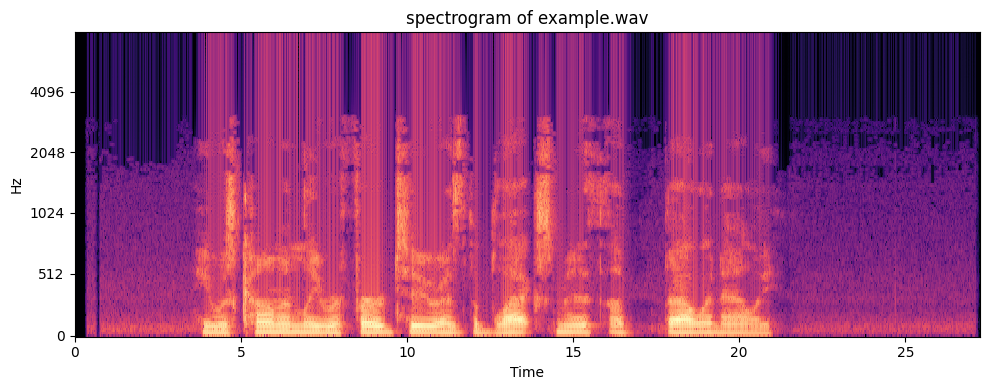

In [53]:
visualization_spectrogram(spects, 'spectrogram of example.wav')

In [28]:
class MaskConv(nn.Module):
    def __init__(self, seq_module):
        """
        Adds padding to the output of the module based on the given lengths. This is to ensure that the
        results of the model do not change when batch sizes change during inference.
        Input needs to be in the shape of (BxCxDxT)
        :param seq_module: The sequential module containing the conv stack.
        """
        super(MaskConv, self).__init__()
        self.seq_module = seq_module

    def forward(self, x, lengths):
        """
        :param x: The input of size BxCxDxT
        :param lengths: The actual length of each sequence in the batch
        :return: Masked output from the module
        """
        for module in self.seq_module:
            x = module(x)
            mask = torch.BoolTensor(x.size()).fill_(0)
            if x.is_cuda:
                mask = mask.cuda()
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths

In [37]:
# params for training...

class Parser:
    """Parameters for training"""
    def __init__(self):
        self.lr = 3e-4
        # self.lr = 4e-4
        self.epochs = 200
        self.batch_size = 10
        self.num_workers = 1
        self.hidden_size = 200
        self.hidden_layers = 5
        self.bidirectional = True
        self.seed = 42
        self.momentum = 0.9
        self.wd = 1e-5
        self.opt_level = 'O0'
        self.keep_batchnorm_fp32 = None
        self.loss_scale = 1
        # self.max_norm = 400
        self.max_norm = 300
        self.checkpoint_per_iteration = 0
        self.checkpoint = False
        self.save_folder = 'snapshots'
        self.best_val_model_name = "deepspeech_final.pth"
        self.save_n_recent_models = 0
        self.learning_anneal = 1.01
        self.eps = 1e-8 # for adamw
        self.betas = (0.9, 0.999) # for adamw

args = Parser()

In [38]:
# set rnn type
rnn_type = 'rnn'

# prepare model
model = DeepSpeech(rnn_hidden_size=args.hidden_size,
                   nb_layers=args.hidden_layers,
                   labels=labels,
                   rnn_type=supported_rnns[rnn_type],
                   audio_conf=audio_conf,
                   bidirectional=args.bidirectional)

In [39]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")


Number of parameters: 1519568


In [40]:
# use TrainingState to track training state
state = TrainingState(model=model)
state.init_results_tracking(epochs=args.epochs)

In [41]:
evaluation_decoder = GreedyDecoder(model.labels)  # Decoder used for validation

In [42]:
# device = torch.device("cpu" if args.no_cuda else "cuda")
# ctc-loos works only with gpu?
device = torch.device("cuda")

In [43]:
# optim
model = model.to(device)
parameters = model.parameters()

In [44]:
optimizer = torch.optim.AdamW(parameters,
                              lr=args.lr,
                              betas=args.betas,
                              eps=args.eps,
                              weight_decay=args.wd)

In [45]:
# Track states for optimizer
state.track_optim_state(optimizer)

In [46]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [47]:
# use CTC for our loss
criterion = nn.CTCLoss(blank=labels.index('_'),reduction='sum', zero_infinity=True)
batch_time = AverageMeter()
data_time = AverageMeter()
losses = AverageMeter()


In [48]:
# prepare check point handler
checkpoint_handler = CheckpointHandler(save_folder=args.save_folder,
                                       best_val_model_name=args.best_val_model_name,
                                       checkpoint_per_iteration=args.checkpoint_per_iteration,
                                       save_n_recent_models=args.save_n_recent_models)


In [49]:
# model = load_model("cuda", "./snapshots/deepspeech_final.pth", False)

In [50]:
train_loss_vals = []

In [51]:
# training loop

main_proc = True

for epoch in range(state.epoch, args.epochs):
    model.train()
    end = time.time()
    start_epoch_time = time.time()
    state.set_epoch(epoch=epoch)
    train_sampler.set_epoch(epoch=epoch)
    train_sampler.reset_training_step(training_step=state.training_step)
    for idx, (data) in enumerate(train_loader, start=state.training_step):
        state.set_training_step(training_step=idx)
        inputs, targets, input_percentages, target_sizes = data
        input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
        # measure data loading time
        data_time.update(time.time() - end)
        inputs = inputs.to(device)

        out, output_sizes = model(inputs, input_sizes)
        out = out.transpose(0, 1)  # TxNxH
        out = out.log_softmax(-1)
#         print(len(out))
        float_out = out.float()  # ensure float32 for loss
        
#         print(len(targets))
        loss = criterion(float_out, targets, output_sizes, target_sizes).to(device)
        loss = loss / inputs.size(0)  # average the loss by minibatch
        loss_value = loss.item()

        # Check to ensure valid loss was calculated
        valid_loss, error = check_loss(loss, loss_value)
        if valid_loss:
            train_loss_vals.append(loss_value)
            optimizer.zero_grad()
            
            # compute gradient
            loss.backward()
    
            torch.nn.utils.clip_grad_norm_(parameters, args.max_norm)
            optimizer.step()
        else:
            print(error)
            print('Skipping grad update')
            loss_value = 0

        state.avg_loss += loss_value
        losses.update(loss_value, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if idx % 5 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                (epoch + 1), (idx + 1), len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses))

        if main_proc and args.checkpoint_per_iteration:
            checkpoint_handler.save_iter_checkpoint_model(epoch=epoch, i=idx, state=state)
            
        del loss, out, float_out

    state.avg_loss /= len(training_data)

    epoch_time = time.time() - start_epoch_time
    print('Training Summary Epoch: [{0}]\t'
          'Time taken (s): {epoch_time:.0f}\t'
          'Average Loss {loss:.3f}\t'.format(epoch + 1, epoch_time=epoch_time, loss=state.avg_loss))

    with torch.no_grad():
        wer, cer, output_data = evaluate(test_loader=valid_loader,
                                         device=device,
                                         model=model,
                                         decoder=evaluation_decoder,
                                         target_decoder=evaluation_decoder)

    state.add_results(epoch=epoch,
                      loss_result=state.avg_loss,
                      wer_result=wer,
                      cer_result=cer)

    print('Validation Summary Epoch: [{0}]\t'
          'Average WER {wer:.3f}\t'
          'Average CER {cer:.3f}\t'.format(epoch + 1, wer=wer, cer=cer))

    if main_proc and args.checkpoint:  # Save epoch checkpoint
        checkpoint_handler.save_checkpoint_model(epoch=epoch, state=state)
    # anneal lr
    for g in optimizer.param_groups:
        g['lr'] = g['lr'] / args.learning_anneal
    print('Learning rate annealed to: {lr:.6f}'.format(lr=g['lr']))

    if main_proc and (state.best_wer is None or state.best_wer > wer):
        checkpoint_handler.save_best_model(epoch=epoch, state=state)
        state.set_best_wer(wer)
        state.reset_avg_loss()
    state.reset_training_step()

Epoch: [1][1/20]	Time 2.827 (2.827)	Data 1.291 (1.291)	Loss 974.2545 (974.2545)	
Epoch: [1][6/20]	Time 0.808 (0.978)	Data 0.002 (0.217)	Loss 472.8589 (678.5852)	
Epoch: [1][11/20]	Time 0.678 (0.867)	Data 0.002 (0.119)	Loss 223.9640 (523.8746)	
Epoch: [1][16/20]	Time 0.841 (0.822)	Data 0.002 (0.082)	Loss 364.9204 (475.2100)	
Training Summary Epoch: [1]	Time taken (s): 16	Average Loss 92.903	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

Validation Summary Epoch: [1]	Average WER 100.000	Average CER 94.536	
Learning rate annealed to: 0.000297
Found better validated model, saving to snapshots/deepspeech_final.pth


Epoch: [2][1/20]	Time 1.206 (0.825)	Data 0.871 (0.105)	Loss 330.9996 (433.3470)	
Epoch: [2][6/20]	Time 0.442 (0.789)	Data 0.002 (0.085)	Loss 333.5690 (412.1019)	
Epoch: [2][11/20]	Time 0.641 (0.778)	Data 0.002 (0.072)	Loss 180.6015 (392.1638)	
Epoch: [2][16/20]	Time 0.791 (0.771)	Data 0.002 (0.062)	Loss 212.6733 (375.0886)	
Training Summary Epoch: [2]	Time taken (s): 15	Average Loss 60.637	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Validation Summary Epoch: [2]	Average WER 100.000	Average CER 94.536	
Learning rate annealed to: 0.000294


Epoch: [3][1/20]	Time 1.250 (0.782)	Data 0.879 (0.076)	Loss 319.7148 (363.4681)	
Epoch: [3][6/20]	Time 0.796 (0.766)	Data 0.002 (0.068)	Loss 232.3071 (350.6946)	
Epoch: [3][11/20]	Time 0.740 (0.766)	Data 0.002 (0.061)	Loss 309.3698 (344.7849)	
Epoch: [3][16/20]	Time 0.631 (0.759)	Data 0.002 (0.056)	Loss 311.8478 (338.3924)	
Training Summary Epoch: [3]	Time taken (s): 15	Average Loss 55.445	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

Validation Summary Epoch: [3]	Average WER 100.000	Average CER 90.710	
Learning rate annealed to: 0.000291


Epoch: [4][1/20]	Time 1.133 (0.766)	Data 0.912 (0.067)	Loss 197.2041 (328.7836)	
Epoch: [4][6/20]	Time 0.769 (0.768)	Data 0.002 (0.062)	Loss 259.8230 (323.8768)	
Epoch: [4][11/20]	Time 0.787 (0.770)	Data 0.002 (0.058)	Loss 217.1125 (320.4321)	
Epoch: [4][16/20]	Time 0.746 (0.762)	Data 0.002 (0.054)	Loss 239.3023 (314.3935)	
Training Summary Epoch: [4]	Time taken (s): 15	Average Loss 53.981	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

Validation Summary Epoch: [4]	Average WER 100.000	Average CER 89.071	
Learning rate annealed to: 0.000288


Epoch: [5][1/20]	Time 1.188 (0.760)	Data 0.869 (0.061)	Loss 191.4973 (311.0879)	
Epoch: [5][6/20]	Time 0.708 (0.761)	Data 0.002 (0.058)	Loss 342.8304 (308.9656)	
Epoch: [5][11/20]	Time 0.551 (0.758)	Data 0.002 (0.055)	Loss 302.8442 (304.9550)	
Epoch: [5][16/20]	Time 0.754 (0.750)	Data 0.002 (0.052)	Loss 242.1190 (300.9052)	
Training Summary Epoch: [5]	Time taken (s): 15	Average Loss 52.496	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Validation Summary Epoch: [5]	Average WER 100.000	Average CER 89.617	
Learning rate annealed to: 0.000285


Epoch: [6][1/20]	Time 1.216 (0.756)	Data 0.928 (0.059)	Loss 138.0491 (298.5513)	
Epoch: [6][6/20]	Time 0.805 (0.755)	Data 0.002 (0.056)	Loss 236.7654 (294.0903)	
Epoch: [6][11/20]	Time 0.665 (0.754)	Data 0.002 (0.054)	Loss 294.0320 (293.2620)	
Epoch: [6][16/20]	Time 0.780 (0.752)	Data 0.002 (0.051)	Loss 282.2545 (291.4931)	
Training Summary Epoch: [6]	Time taken (s): 15	Average Loss 50.839	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

Validation Summary Epoch: [6]	Average WER 100.000	Average CER 83.607	
Learning rate annealed to: 0.000283


Epoch: [7][1/20]	Time 1.242 (0.755)	Data 0.920 (0.057)	Loss 191.7581 (289.7289)	
Epoch: [7][6/20]	Time 0.870 (0.756)	Data 0.002 (0.055)	Loss 287.7673 (287.2195)	
Epoch: [7][11/20]	Time 0.792 (0.755)	Data 0.002 (0.053)	Loss 273.7191 (285.7336)	
Epoch: [7][16/20]	Time 0.734 (0.752)	Data 0.002 (0.051)	Loss 222.8059 (283.3802)	
Training Summary Epoch: [7]	Time taken (s): 15	Average Loss 48.885	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

Validation Summary Epoch: [7]	Average WER 100.000	Average CER 86.885	
Learning rate annealed to: 0.000280


Epoch: [8][1/20]	Time 1.183 (0.753)	Data 0.882 (0.055)	Loss 204.1985 (281.8105)	
Epoch: [8][6/20]	Time 0.755 (0.754)	Data 0.002 (0.054)	Loss 227.6358 (280.4651)	
Epoch: [8][11/20]	Time 0.637 (0.751)	Data 0.002 (0.052)	Loss 301.2995 (278.5005)	
Epoch: [8][16/20]	Time 0.574 (0.751)	Data 0.002 (0.050)	Loss 185.2925 (277.3900)	
Training Summary Epoch: [8]	Time taken (s): 15	Average Loss 47.667	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

Validation Summary Epoch: [8]	Average WER 100.000	Average CER 87.978	
Learning rate annealed to: 0.000277


Epoch: [9][1/20]	Time 1.342 (0.752)	Data 0.936 (0.055)	Loss 177.1875 (274.9377)	
Epoch: [9][6/20]	Time 0.661 (0.750)	Data 0.003 (0.053)	Loss 176.1246 (272.8815)	
Epoch: [9][11/20]	Time 0.637 (0.748)	Data 0.002 (0.052)	Loss 154.1953 (271.6375)	
Epoch: [9][16/20]	Time 0.865 (0.746)	Data 0.002 (0.050)	Loss 204.5885 (270.5955)	
Training Summary Epoch: [9]	Time taken (s): 15	Average Loss 46.126	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

Validation Summary Epoch: [9]	Average WER 105.882	Average CER 84.699	
Learning rate annealed to: 0.000274


Epoch: [10][1/20]	Time 1.252 (0.750)	Data 0.924 (0.054)	Loss 166.4921 (268.8430)	
Epoch: [10][6/20]	Time 0.573 (0.750)	Data 0.002 (0.053)	Loss 195.3390 (267.0343)	
Epoch: [10][11/20]	Time 0.685 (0.748)	Data 0.002 (0.051)	Loss 233.9071 (266.0043)	
Epoch: [10][16/20]	Time 0.735 (0.749)	Data 0.002 (0.050)	Loss 138.9687 (264.4059)	
Training Summary Epoch: [10]	Time taken (s): 15	Average Loss 44.667	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

Validation Summary Epoch: [10]	Average WER 114.706	Average CER 81.421	
Learning rate annealed to: 0.000272


Epoch: [11][1/20]	Time 1.232 (0.749)	Data 0.924 (0.053)	Loss 194.7721 (263.4671)	
Epoch: [11][6/20]	Time 0.741 (0.748)	Data 0.002 (0.052)	Loss 167.7036 (261.9211)	
Epoch: [11][11/20]	Time 0.786 (0.748)	Data 0.002 (0.051)	Loss 284.7268 (260.8659)	
Epoch: [11][16/20]	Time 0.706 (0.747)	Data 0.002 (0.050)	Loss 225.2742 (259.5192)	
Training Summary Epoch: [11]	Time taken (s): 15	Average Loss 43.708	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Validation Summary Epoch: [11]	Average WER 108.824	Average CER 86.885	
Learning rate annealed to: 0.000269


Epoch: [12][1/20]	Time 1.266 (0.748)	Data 0.937 (0.053)	Loss 209.1578 (258.6122)	
Epoch: [12][6/20]	Time 0.601 (0.748)	Data 0.002 (0.052)	Loss 191.8084 (257.3471)	
Epoch: [12][11/20]	Time 0.888 (0.749)	Data 0.002 (0.051)	Loss 262.5752 (256.1393)	
Epoch: [12][16/20]	Time 0.764 (0.748)	Data 0.002 (0.050)	Loss 191.6628 (254.4934)	
Training Summary Epoch: [12]	Time taken (s): 15	Average Loss 43.299	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

Validation Summary Epoch: [12]	Average WER 100.000	Average CER 86.885	
Learning rate annealed to: 0.000266


Epoch: [13][1/20]	Time 1.361 (0.749)	Data 0.962 (0.053)	Loss 168.9299 (254.1114)	
Epoch: [13][6/20]	Time 0.713 (0.750)	Data 0.002 (0.052)	Loss 324.0095 (253.8636)	
Epoch: [13][11/20]	Time 0.687 (0.749)	Data 0.002 (0.051)	Loss 194.1719 (252.6438)	
Epoch: [13][16/20]	Time 0.663 (0.748)	Data 0.002 (0.050)	Loss 147.0854 (252.0208)	
Training Summary Epoch: [13]	Time taken (s): 15	Average Loss 44.103	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Validation Summary Epoch: [13]	Average WER 105.882	Average CER 83.060	
Learning rate annealed to: 0.000264


Epoch: [14][1/20]	Time 1.212 (0.749)	Data 0.937 (0.052)	Loss 225.0307 (251.0346)	
Epoch: [14][6/20]	Time 0.708 (0.747)	Data 0.002 (0.051)	Loss 273.2678 (250.0548)	
Epoch: [14][11/20]	Time 0.771 (0.748)	Data 0.002 (0.051)	Loss 190.6017 (249.2386)	
Epoch: [14][16/20]	Time 0.807 (0.748)	Data 0.002 (0.050)	Loss 253.8595 (248.1386)	
Training Summary Epoch: [14]	Time taken (s): 15	Average Loss 42.566	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

Validation Summary Epoch: [14]	Average WER 105.882	Average CER 82.514	
Learning rate annealed to: 0.000261


Epoch: [15][1/20]	Time 1.256 (0.749)	Data 0.951 (0.052)	Loss 193.6472 (247.5625)	
Epoch: [15][6/20]	Time 0.803 (0.747)	Data 0.002 (0.051)	Loss 238.9126 (246.6780)	
Epoch: [15][11/20]	Time 0.703 (0.746)	Data 0.002 (0.051)	Loss 216.7543 (246.0784)	
Epoch: [15][16/20]	Time 0.766 (0.747)	Data 0.002 (0.050)	Loss 207.1904 (245.2196)	
Training Summary Epoch: [15]	Time taken (s): 15	Average Loss 42.075	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

Validation Summary Epoch: [15]	Average WER 105.882	Average CER 83.060	
Learning rate annealed to: 0.000258


Epoch: [16][1/20]	Time 1.396 (0.749)	Data 0.971 (0.052)	Loss 243.4323 (244.6814)	
Epoch: [16][6/20]	Time 0.820 (0.749)	Data 0.002 (0.051)	Loss 185.8850 (243.8418)	
Epoch: [16][11/20]	Time 0.698 (0.747)	Data 0.002 (0.051)	Loss 182.8091 (243.0006)	
Epoch: [16][16/20]	Time 0.584 (0.747)	Data 0.002 (0.050)	Loss 193.0873 (242.0135)	
Training Summary Epoch: [16]	Time taken (s): 15	Average Loss 41.185	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

Validation Summary Epoch: [16]	Average WER 100.000	Average CER 83.607	
Learning rate annealed to: 0.000256


Epoch: [17][1/20]	Time 1.340 (0.749)	Data 1.023 (0.052)	Loss 189.3232 (241.5606)	
Epoch: [17][6/20]	Time 0.791 (0.747)	Data 0.002 (0.051)	Loss 190.0906 (240.9174)	
Epoch: [17][11/20]	Time 0.672 (0.747)	Data 0.002 (0.051)	Loss 185.5006 (240.5215)	
Epoch: [17][16/20]	Time 0.569 (0.747)	Data 0.002 (0.050)	Loss 164.6394 (239.9418)	
Training Summary Epoch: [17]	Time taken (s): 15	Average Loss 41.292	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

Validation Summary Epoch: [17]	Average WER 102.941	Average CER 83.060	
Learning rate annealed to: 0.000253


Epoch: [18][1/20]	Time 1.128 (0.748)	Data 0.936 (0.052)	Loss 202.0348 (239.1083)	
Epoch: [18][6/20]	Time 0.791 (0.747)	Data 0.002 (0.051)	Loss 224.8287 (238.6013)	
Epoch: [18][11/20]	Time 0.932 (0.747)	Data 0.002 (0.051)	Loss 238.7375 (237.7876)	
Epoch: [18][16/20]	Time 0.675 (0.748)	Data 0.002 (0.050)	Loss 211.7821 (237.3534)	
Training Summary Epoch: [18]	Time taken (s): 15	Average Loss 40.197	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

Validation Summary Epoch: [18]	Average WER 117.647	Average CER 78.689	
Learning rate annealed to: 0.000251


Epoch: [19][1/20]	Time 1.160 (0.748)	Data 0.931 (0.052)	Loss 157.4948 (236.3418)	
Epoch: [19][6/20]	Time 0.540 (0.748)	Data 0.002 (0.051)	Loss 189.4482 (235.7855)	
Epoch: [19][11/20]	Time 0.789 (0.748)	Data 0.002 (0.050)	Loss 247.0745 (235.2369)	
Epoch: [19][16/20]	Time 0.755 (0.748)	Data 0.002 (0.050)	Loss 181.3002 (234.4429)	
Training Summary Epoch: [19]	Time taken (s): 15	Average Loss 39.440	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

Validation Summary Epoch: [19]	Average WER 108.824	Average CER 80.328	
Learning rate annealed to: 0.000248


Epoch: [20][1/20]	Time 1.322 (0.749)	Data 0.979 (0.052)	Loss 201.3797 (233.9898)	
Epoch: [20][6/20]	Time 0.876 (0.749)	Data 0.002 (0.051)	Loss 216.5539 (233.3753)	
Epoch: [20][11/20]	Time 0.726 (0.750)	Data 0.002 (0.051)	Loss 149.6202 (232.7298)	
Epoch: [20][16/20]	Time 0.802 (0.748)	Data 0.002 (0.050)	Loss 186.1039 (232.2740)	
Training Summary Epoch: [20]	Time taken (s): 15	Average Loss 38.923	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Validation Summary Epoch: [20]	Average WER 111.765	Average CER 77.596	
Learning rate annealed to: 0.000246


Epoch: [21][1/20]	Time 1.233 (0.749)	Data 0.942 (0.052)	Loss 117.1120 (231.4203)	
Epoch: [21][6/20]	Time 0.680 (0.748)	Data 0.002 (0.051)	Loss 148.1152 (230.9624)	
Epoch: [21][11/20]	Time 0.699 (0.746)	Data 0.002 (0.050)	Loss 147.3065 (230.1341)	
Epoch: [21][16/20]	Time 0.733 (0.747)	Data 0.002 (0.050)	Loss 184.4204 (229.9391)	
Training Summary Epoch: [21]	Time taken (s): 15	Average Loss 39.106	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

Validation Summary Epoch: [21]	Average WER 108.824	Average CER 78.142	
Learning rate annealed to: 0.000243


Epoch: [22][1/20]	Time 1.208 (0.748)	Data 0.925 (0.051)	Loss 172.9542 (229.4887)	
Epoch: [22][6/20]	Time 0.610 (0.748)	Data 0.002 (0.051)	Loss 174.6225 (229.1585)	
Epoch: [22][11/20]	Time 0.647 (0.747)	Data 0.002 (0.050)	Loss 211.7966 (228.7699)	
Epoch: [22][16/20]	Time 0.844 (0.748)	Data 0.002 (0.050)	Loss 176.8275 (228.0504)	
Training Summary Epoch: [22]	Time taken (s): 15	Average Loss 38.217	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Validation Summary Epoch: [22]	Average WER 102.941	Average CER 80.328	
Learning rate annealed to: 0.000241


Epoch: [23][1/20]	Time 1.292 (0.748)	Data 0.928 (0.051)	Loss 215.2207 (227.5095)	
Epoch: [23][6/20]	Time 0.773 (0.749)	Data 0.002 (0.051)	Loss 173.1939 (227.0707)	
Epoch: [23][11/20]	Time 0.678 (0.749)	Data 0.002 (0.050)	Loss 110.9031 (226.6364)	
Epoch: [23][16/20]	Time 0.557 (0.748)	Data 0.002 (0.050)	Loss 176.0591 (225.9140)	
Training Summary Epoch: [23]	Time taken (s): 15	Average Loss 37.863	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

Validation Summary Epoch: [23]	Average WER 102.941	Average CER 78.689	
Learning rate annealed to: 0.000239


Epoch: [24][1/20]	Time 1.293 (0.748)	Data 1.004 (0.051)	Loss 105.5790 (225.2856)	
Epoch: [24][6/20]	Time 0.763 (0.748)	Data 0.002 (0.051)	Loss 221.2243 (224.6966)	
Epoch: [24][11/20]	Time 0.665 (0.748)	Data 0.002 (0.050)	Loss 169.6789 (224.1464)	
Epoch: [24][16/20]	Time 0.602 (0.748)	Data 0.002 (0.050)	Loss 162.6734 (223.6624)	
Training Summary Epoch: [24]	Time taken (s): 15	Average Loss 36.719	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

Validation Summary Epoch: [24]	Average WER 102.941	Average CER 78.689	
Learning rate annealed to: 0.000236


Epoch: [25][1/20]	Time 1.412 (0.748)	Data 1.015 (0.051)	Loss 159.7534 (223.3750)	
Epoch: [25][6/20]	Time 0.800 (0.749)	Data 0.002 (0.051)	Loss 175.8895 (222.8464)	
Epoch: [25][11/20]	Time 0.652 (0.747)	Data 0.002 (0.050)	Loss 239.8466 (222.3474)	
Epoch: [25][16/20]	Time 0.650 (0.747)	Data 0.002 (0.050)	Loss 146.6670 (221.7331)	
Training Summary Epoch: [25]	Time taken (s): 15	Average Loss 36.302	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

Validation Summary Epoch: [25]	Average WER 102.941	Average CER 79.235	
Learning rate annealed to: 0.000234


Epoch: [26][1/20]	Time 1.441 (0.749)	Data 1.013 (0.051)	Loss 190.4969 (221.4866)	
Epoch: [26][6/20]	Time 0.678 (0.749)	Data 0.002 (0.051)	Loss 192.6555 (220.9221)	
Epoch: [26][11/20]	Time 0.786 (0.749)	Data 0.002 (0.051)	Loss 181.0552 (220.4166)	
Epoch: [26][16/20]	Time 0.777 (0.748)	Data 0.002 (0.050)	Loss 211.1252 (220.1587)	
Training Summary Epoch: [26]	Time taken (s): 15	Average Loss 35.288	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Validation Summary Epoch: [26]	Average WER 114.706	Average CER 80.328	
Learning rate annealed to: 0.000232


Epoch: [27][1/20]	Time 1.362 (0.749)	Data 0.988 (0.051)	Loss 188.6909 (219.4915)	
Epoch: [27][6/20]	Time 0.711 (0.748)	Data 0.002 (0.051)	Loss 228.1833 (219.1001)	
Epoch: [27][11/20]	Time 0.875 (0.748)	Data 0.002 (0.051)	Loss 166.5082 (218.6382)	
Epoch: [27][16/20]	Time 0.716 (0.748)	Data 0.002 (0.050)	Loss 207.1172 (217.9868)	
Training Summary Epoch: [27]	Time taken (s): 15	Average Loss 34.157	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Validation Summary Epoch: [27]	Average WER 105.882	Average CER 78.689	
Learning rate annealed to: 0.000229


Epoch: [28][1/20]	Time 1.267 (0.748)	Data 1.071 (0.052)	Loss 149.1489 (217.4599)	
Epoch: [28][6/20]	Time 0.810 (0.748)	Data 0.003 (0.051)	Loss 219.8000 (216.9818)	
Epoch: [28][11/20]	Time 0.818 (0.748)	Data 0.002 (0.051)	Loss 223.9738 (216.6815)	
Epoch: [28][16/20]	Time 0.767 (0.748)	Data 0.003 (0.050)	Loss 177.0299 (216.0059)	
Training Summary Epoch: [28]	Time taken (s): 15	Average Loss 34.407	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Validation Summary Epoch: [28]	Average WER 132.353	Average CER 78.142	
Learning rate annealed to: 0.000227


Epoch: [29][1/20]	Time 1.278 (0.749)	Data 0.967 (0.052)	Loss 149.2173 (215.5382)	
Epoch: [29][6/20]	Time 0.845 (0.749)	Data 0.002 (0.051)	Loss 149.8707 (215.0332)	
Epoch: [29][11/20]	Time 0.733 (0.749)	Data 0.002 (0.051)	Loss 183.7626 (214.5078)	
Epoch: [29][16/20]	Time 0.636 (0.749)	Data 0.002 (0.050)	Loss 103.5681 (214.0142)	
Training Summary Epoch: [29]	Time taken (s): 15	Average Loss 33.508	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Validation Summary Epoch: [29]	Average WER 100.000	Average CER 76.503	
Learning rate annealed to: 0.000225


Epoch: [30][1/20]	Time 1.299 (0.749)	Data 0.954 (0.052)	Loss 165.7052 (213.7019)	
Epoch: [30][6/20]	Time 0.590 (0.749)	Data 0.002 (0.051)	Loss 210.0072 (213.3216)	
Epoch: [30][11/20]	Time 0.667 (0.748)	Data 0.002 (0.051)	Loss 136.5946 (212.8895)	
Epoch: [30][16/20]	Time 0.846 (0.748)	Data 0.002 (0.050)	Loss 156.6092 (212.3027)	
Training Summary Epoch: [30]	Time taken (s): 15	Average Loss 31.939	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Validation Summary Epoch: [30]	Average WER 102.941	Average CER 78.689	
Learning rate annealed to: 0.000223


Epoch: [31][1/20]	Time 1.289 (0.749)	Data 0.972 (0.052)	Loss 133.6155 (211.6517)	
Epoch: [31][6/20]	Time 0.906 (0.750)	Data 0.002 (0.051)	Loss 128.7205 (211.0188)	
Epoch: [31][11/20]	Time 0.812 (0.749)	Data 0.002 (0.051)	Loss 199.3107 (210.4227)	
Epoch: [31][16/20]	Time 0.878 (0.749)	Data 0.003 (0.050)	Loss 169.0195 (210.0083)	
Training Summary Epoch: [31]	Time taken (s): 15	Average Loss 30.518	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

Validation Summary Epoch: [31]	Average WER 108.824	Average CER 77.049	
Learning rate annealed to: 0.000220


Epoch: [32][1/20]	Time 1.267 (0.749)	Data 1.041 (0.052)	Loss 117.7057 (209.5499)	
Epoch: [32][6/20]	Time 0.583 (0.749)	Data 0.002 (0.051)	Loss 78.7727 (208.8815)	
Epoch: [32][11/20]	Time 0.680 (0.749)	Data 0.002 (0.051)	Loss 194.1374 (208.4924)	
Epoch: [32][16/20]	Time 0.770 (0.749)	Data 0.002 (0.050)	Loss 185.9637 (207.9640)	
Training Summary Epoch: [32]	Time taken (s): 15	Average Loss 29.395	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

Validation Summary Epoch: [32]	Average WER 102.941	Average CER 76.503	
Learning rate annealed to: 0.000218


Epoch: [33][1/20]	Time 1.301 (0.750)	Data 0.988 (0.052)	Loss 127.4373 (207.4467)	
Epoch: [33][6/20]	Time 0.766 (0.750)	Data 0.002 (0.051)	Loss 100.0392 (206.8617)	
Epoch: [33][11/20]	Time 0.695 (0.750)	Data 0.002 (0.051)	Loss 171.8243 (206.3603)	
Epoch: [33][16/20]	Time 0.663 (0.750)	Data 0.002 (0.050)	Loss 121.2149 (205.8056)	
Training Summary Epoch: [33]	Time taken (s): 15	Average Loss 28.145	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

Validation Summary Epoch: [33]	Average WER 105.882	Average CER 76.503	
Learning rate annealed to: 0.000216


Epoch: [34][1/20]	Time 1.365 (0.750)	Data 0.998 (0.052)	Loss 135.9105 (205.2869)	
Epoch: [34][6/20]	Time 0.653 (0.749)	Data 0.002 (0.051)	Loss 165.5622 (204.7933)	
Epoch: [34][11/20]	Time 0.755 (0.750)	Data 0.002 (0.051)	Loss 118.6886 (204.2243)	
Epoch: [34][16/20]	Time 0.488 (0.749)	Data 0.002 (0.051)	Loss 135.0067 (203.6735)	
Training Summary Epoch: [34]	Time taken (s): 15	Average Loss 26.487	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

Validation Summary Epoch: [34]	Average WER 105.882	Average CER 79.781	
Learning rate annealed to: 0.000214


Epoch: [35][1/20]	Time 1.258 (0.750)	Data 0.969 (0.052)	Loss 112.5407 (202.9736)	
Epoch: [35][6/20]	Time 0.828 (0.750)	Data 0.003 (0.051)	Loss 105.2763 (202.2752)	
Epoch: [35][11/20]	Time 0.812 (0.750)	Data 0.002 (0.051)	Loss 124.9314 (201.7147)	
Epoch: [35][16/20]	Time 0.542 (0.749)	Data 0.002 (0.051)	Loss 130.7328 (201.2467)	
Training Summary Epoch: [35]	Time taken (s): 15	Average Loss 24.737	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Validation Summary Epoch: [35]	Average WER 111.765	Average CER 77.596	
Learning rate annealed to: 0.000212


Epoch: [36][1/20]	Time 1.429 (0.750)	Data 1.114 (0.052)	Loss 94.4842 (200.5622)	
Epoch: [36][6/20]	Time 0.714 (0.750)	Data 0.002 (0.051)	Loss 103.0251 (199.9516)	
Epoch: [36][11/20]	Time 0.793 (0.750)	Data 0.003 (0.051)	Loss 83.1405 (199.1003)	
Epoch: [36][16/20]	Time 0.736 (0.749)	Data 0.002 (0.051)	Loss 140.0613 (198.6971)	
Training Summary Epoch: [36]	Time taken (s): 15	Average Loss 23.011	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Validation Summary Epoch: [36]	Average WER 102.941	Average CER 77.049	
Learning rate annealed to: 0.000210


Epoch: [37][1/20]	Time 1.417 (0.750)	Data 1.075 (0.052)	Loss 112.3531 (198.1052)	
Epoch: [37][6/20]	Time 0.576 (0.750)	Data 0.002 (0.052)	Loss 150.3172 (197.5667)	
Epoch: [37][11/20]	Time 0.671 (0.750)	Data 0.002 (0.051)	Loss 107.2690 (196.8863)	
Epoch: [37][16/20]	Time 0.786 (0.750)	Data 0.002 (0.051)	Loss 119.6612 (196.2278)	
Training Summary Epoch: [37]	Time taken (s): 15	Average Loss 22.136	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

Validation Summary Epoch: [37]	Average WER 126.471	Average CER 76.503	
Learning rate annealed to: 0.000208


Epoch: [38][1/20]	Time 1.361 (0.750)	Data 1.070 (0.052)	Loss 53.4667 (195.5593)	
Epoch: [38][6/20]	Time 0.706 (0.750)	Data 0.002 (0.052)	Loss 114.0073 (195.0605)	
Epoch: [38][11/20]	Time 0.685 (0.750)	Data 0.002 (0.051)	Loss 119.4894 (194.4602)	
Epoch: [38][16/20]	Time 0.695 (0.750)	Data 0.002 (0.051)	Loss 112.7338 (193.9114)	
Training Summary Epoch: [38]	Time taken (s): 15	Average Loss 22.242	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

Validation Summary Epoch: [38]	Average WER 129.412	Average CER 79.235	
Learning rate annealed to: 0.000206


Epoch: [39][1/20]	Time 1.375 (0.751)	Data 1.055 (0.052)	Loss 85.5167 (193.2895)	
Epoch: [39][6/20]	Time 0.683 (0.750)	Data 0.002 (0.052)	Loss 81.9197 (192.5397)	
Epoch: [39][11/20]	Time 0.815 (0.750)	Data 0.002 (0.051)	Loss 105.9334 (191.9593)	
Epoch: [39][16/20]	Time 0.394 (0.750)	Data 0.002 (0.051)	Loss 91.4118 (191.4436)	
Training Summary Epoch: [39]	Time taken (s): 15	Average Loss 20.489	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [39]	Average WER 129.412	Average CER 83.060	
Learning rate annealed to: 0.000204


Epoch: [40][1/20]	Time 1.441 (0.751)	Data 1.071 (0.052)	Loss 102.9865 (190.8949)	
Epoch: [40][6/20]	Time 0.735 (0.750)	Data 0.002 (0.052)	Loss 141.9992 (190.2397)	
Epoch: [40][11/20]	Time 0.714 (0.750)	Data 0.002 (0.052)	Loss 107.1820 (189.5831)	
Epoch: [40][16/20]	Time 0.761 (0.750)	Data 0.003 (0.051)	Loss 143.4325 (189.1184)	
Training Summary Epoch: [40]	Time taken (s): 15	Average Loss 19.854	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [40]	Average WER 114.706	Average CER 79.781	
Learning rate annealed to: 0.000201


Epoch: [41][1/20]	Time 1.279 (0.750)	Data 1.003 (0.052)	Loss 116.4389 (188.5403)	
Epoch: [41][6/20]	Time 0.900 (0.750)	Data 0.002 (0.052)	Loss 97.3634 (187.9756)	
Epoch: [41][11/20]	Time 0.706 (0.750)	Data 0.002 (0.052)	Loss 91.3860 (187.3766)	
Epoch: [41][16/20]	Time 0.727 (0.750)	Data 0.002 (0.051)	Loss 127.6010 (186.7154)	
Training Summary Epoch: [41]	Time taken (s): 15	Average Loss 18.161	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [41]	Average WER 120.588	Average CER 75.956	
Learning rate annealed to: 0.000200


Epoch: [42][1/20]	Time 1.377 (0.750)	Data 1.084 (0.052)	Loss 124.5091 (186.0913)	
Epoch: [42][6/20]	Time 0.731 (0.751)	Data 0.002 (0.052)	Loss 63.1944 (185.4549)	
Epoch: [42][11/20]	Time 0.639 (0.750)	Data 0.002 (0.052)	Loss 45.6564 (184.8057)	
Epoch: [42][16/20]	Time 0.697 (0.750)	Data 0.002 (0.051)	Loss 57.0397 (184.1585)	
Training Summary Epoch: [42]	Time taken (s): 15	Average Loss 16.764	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [42]	Average WER 117.647	Average CER 80.874	
Learning rate annealed to: 0.000198


Epoch: [43][1/20]	Time 1.482 (0.751)	Data 1.091 (0.052)	Loss 100.7729 (183.5605)	
Epoch: [43][6/20]	Time 0.760 (0.751)	Data 0.002 (0.052)	Loss 73.9257 (182.9186)	
Epoch: [43][11/20]	Time 0.749 (0.750)	Data 0.002 (0.052)	Loss 83.8727 (182.2010)	
Epoch: [43][16/20]	Time 0.800 (0.750)	Data 0.002 (0.052)	Loss 91.1093 (181.5862)	
Training Summary Epoch: [43]	Time taken (s): 15	Average Loss 16.267	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [43]	Average WER 129.412	Average CER 78.142	
Learning rate annealed to: 0.000196


Epoch: [44][1/20]	Time 1.450 (0.751)	Data 1.081 (0.052)	Loss 84.4665 (181.1007)	
Epoch: [44][6/20]	Time 0.767 (0.750)	Data 0.003 (0.052)	Loss 63.9178 (180.5533)	
Epoch: [44][11/20]	Time 0.772 (0.750)	Data 0.002 (0.052)	Loss 35.4449 (179.8087)	
Epoch: [44][16/20]	Time 0.749 (0.750)	Data 0.002 (0.052)	Loss 104.3598 (179.2324)	
Training Summary Epoch: [44]	Time taken (s): 15	Average Loss 15.070	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

Validation Summary Epoch: [44]	Average WER 108.824	Average CER 80.874	
Learning rate annealed to: 0.000194


Epoch: [45][1/20]	Time 1.558 (0.751)	Data 1.126 (0.053)	Loss 72.9003 (178.6267)	
Epoch: [45][6/20]	Time 0.778 (0.751)	Data 0.002 (0.052)	Loss 52.2966 (177.9117)	
Epoch: [45][11/20]	Time 0.824 (0.751)	Data 0.002 (0.052)	Loss 40.6455 (177.2678)	
Epoch: [45][16/20]	Time 0.735 (0.750)	Data 0.002 (0.052)	Loss 69.5868 (176.7666)	
Training Summary Epoch: [45]	Time taken (s): 15	Average Loss 13.761	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Validation Summary Epoch: [45]	Average WER 129.412	Average CER 79.781	
Learning rate annealed to: 0.000192


Epoch: [46][1/20]	Time 1.370 (0.751)	Data 1.013 (0.053)	Loss 90.3238 (176.1543)	
Epoch: [46][6/20]	Time 0.813 (0.750)	Data 0.002 (0.052)	Loss 81.6595 (175.4833)	
Epoch: [46][11/20]	Time 0.800 (0.750)	Data 0.002 (0.052)	Loss 48.1525 (174.8923)	
Epoch: [46][16/20]	Time 0.696 (0.750)	Data 0.002 (0.052)	Loss 82.0234 (174.2709)	
Training Summary Epoch: [46]	Time taken (s): 15	Average Loss 12.427	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Validation Summary Epoch: [46]	Average WER 126.471	Average CER 78.689	
Learning rate annealed to: 0.000190


Epoch: [47][1/20]	Time 1.363 (0.751)	Data 1.081 (0.053)	Loss 48.6817 (173.5836)	
Epoch: [47][6/20]	Time 0.701 (0.750)	Data 0.003 (0.052)	Loss 50.0420 (172.9204)	
Epoch: [47][11/20]	Time 0.646 (0.750)	Data 0.002 (0.052)	Loss 32.3205 (172.2408)	
Epoch: [47][16/20]	Time 0.751 (0.750)	Data 0.002 (0.052)	Loss 49.1940 (171.6542)	
Training Summary Epoch: [47]	Time taken (s): 15	Average Loss 11.776	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Validation Summary Epoch: [47]	Average WER 123.529	Average CER 80.874	
Learning rate annealed to: 0.000188


Epoch: [48][1/20]	Time 1.403 (0.751)	Data 1.090 (0.053)	Loss 54.7004 (171.1073)	
Epoch: [48][6/20]	Time 0.746 (0.750)	Data 0.003 (0.053)	Loss 51.8040 (170.5943)	
Epoch: [48][11/20]	Time 0.730 (0.750)	Data 0.002 (0.052)	Loss 65.5931 (169.9134)	
Epoch: [48][16/20]	Time 0.753 (0.750)	Data 0.002 (0.052)	Loss 77.6915 (169.3242)	
Training Summary Epoch: [48]	Time taken (s): 15	Average Loss 11.904	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

Validation Summary Epoch: [48]	Average WER 108.824	Average CER 81.421	
Learning rate annealed to: 0.000186


Epoch: [49][1/20]	Time 1.468 (0.751)	Data 1.093 (0.053)	Loss 50.6278 (168.7366)	
Epoch: [49][6/20]	Time 0.580 (0.751)	Data 0.002 (0.053)	Loss 44.0623 (168.1585)	
Epoch: [49][11/20]	Time 0.774 (0.750)	Data 0.002 (0.052)	Loss 43.7187 (167.5618)	
Epoch: [49][16/20]	Time 0.816 (0.750)	Data 0.003 (0.052)	Loss 44.8553 (167.0026)	
Training Summary Epoch: [49]	Time taken (s): 15	Average Loss 11.195	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [49]	Average WER 123.529	Average CER 80.874	
Learning rate annealed to: 0.000184


Epoch: [50][1/20]	Time 1.415 (0.751)	Data 1.095 (0.053)	Loss 40.6787 (166.3870)	
Epoch: [50][6/20]	Time 0.789 (0.751)	Data 0.003 (0.053)	Loss 40.7682 (165.7751)	
Epoch: [50][11/20]	Time 0.712 (0.751)	Data 0.003 (0.052)	Loss 44.6673 (165.1438)	
Epoch: [50][16/20]	Time 0.724 (0.751)	Data 0.002 (0.052)	Loss 52.1721 (164.6013)	
Training Summary Epoch: [50]	Time taken (s): 15	Average Loss 10.695	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

Validation Summary Epoch: [50]	Average WER 129.412	Average CER 81.421	
Learning rate annealed to: 0.000182


Epoch: [51][1/20]	Time 1.446 (0.751)	Data 1.101 (0.053)	Loss 51.7492 (164.1059)	
Epoch: [51][6/20]	Time 0.645 (0.751)	Data 0.003 (0.053)	Loss 29.2966 (163.4894)	
Epoch: [51][11/20]	Time 0.613 (0.750)	Data 0.002 (0.053)	Loss 48.0280 (162.9859)	
Epoch: [51][16/20]	Time 0.719 (0.750)	Data 0.003 (0.052)	Loss 44.2924 (162.4509)	
Training Summary Epoch: [51]	Time taken (s): 15	Average Loss 10.676	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [51]	Average WER 144.118	Average CER 81.967	
Learning rate annealed to: 0.000181


Epoch: [52][1/20]	Time 1.430 (0.751)	Data 1.100 (0.053)	Loss 42.2349 (161.8935)	
Epoch: [52][6/20]	Time 0.869 (0.751)	Data 0.002 (0.053)	Loss 40.5458 (161.3449)	
Epoch: [52][11/20]	Time 0.619 (0.751)	Data 0.002 (0.053)	Loss 54.7490 (160.8088)	
Epoch: [52][16/20]	Time 0.632 (0.751)	Data 0.003 (0.052)	Loss 71.7714 (160.2700)	
Training Summary Epoch: [52]	Time taken (s): 15	Average Loss 10.390	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [52]	Average WER 129.412	Average CER 81.421	
Learning rate annealed to: 0.000179


Epoch: [53][1/20]	Time 1.476 (0.752)	Data 1.104 (0.053)	Loss 44.0543 (159.7497)	
Epoch: [53][6/20]	Time 0.847 (0.751)	Data 0.003 (0.053)	Loss 39.1885 (159.1766)	
Epoch: [53][11/20]	Time 0.751 (0.751)	Data 0.002 (0.053)	Loss 41.4666 (158.6629)	
Epoch: [53][16/20]	Time 0.562 (0.751)	Data 0.002 (0.053)	Loss 58.5757 (158.1844)	
Training Summary Epoch: [53]	Time taken (s): 15	Average Loss 9.654	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Validation Summary Epoch: [53]	Average WER 135.294	Average CER 85.246	
Learning rate annealed to: 0.000177


Epoch: [54][1/20]	Time 1.378 (0.751)	Data 1.095 (0.053)	Loss 37.7170 (157.6106)	
Epoch: [54][6/20]	Time 0.744 (0.751)	Data 0.003 (0.053)	Loss 54.8619 (157.0780)	
Epoch: [54][11/20]	Time 0.780 (0.752)	Data 0.002 (0.053)	Loss 53.8483 (156.5510)	
Epoch: [54][16/20]	Time 0.494 (0.751)	Data 0.002 (0.053)	Loss 38.1416 (156.0462)	
Training Summary Epoch: [54]	Time taken (s): 15	Average Loss 9.026	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

Validation Summary Epoch: [54]	Average WER 132.353	Average CER 82.514	
Learning rate annealed to: 0.000175


Epoch: [55][1/20]	Time 1.387 (0.752)	Data 1.094 (0.053)	Loss 20.6138 (155.4860)	
Epoch: [55][6/20]	Time 0.665 (0.751)	Data 0.002 (0.053)	Loss 41.6214 (154.9157)	
Epoch: [55][11/20]	Time 0.800 (0.752)	Data 0.002 (0.053)	Loss 43.7144 (154.4109)	
Epoch: [55][16/20]	Time 0.611 (0.752)	Data 0.002 (0.053)	Loss 38.1575 (153.8706)	
Training Summary Epoch: [55]	Time taken (s): 15	Average Loss 8.395	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

Validation Summary Epoch: [55]	Average WER 129.412	Average CER 83.060	
Learning rate annealed to: 0.000174


Epoch: [56][1/20]	Time 1.361 (0.752)	Data 1.043 (0.053)	Loss 33.6230 (153.4104)	
Epoch: [56][6/20]	Time 0.566 (0.751)	Data 0.002 (0.053)	Loss 46.3488 (152.9487)	
Epoch: [56][11/20]	Time 0.652 (0.751)	Data 0.002 (0.053)	Loss 29.0831 (152.3954)	
Epoch: [56][16/20]	Time 0.855 (0.751)	Data 0.003 (0.053)	Loss 31.5454 (151.9007)	
Training Summary Epoch: [56]	Time taken (s): 15	Average Loss 7.870	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

Validation Summary Epoch: [56]	Average WER 129.412	Average CER 81.421	
Learning rate annealed to: 0.000172


Epoch: [57][1/20]	Time 1.402 (0.752)	Data 1.024 (0.053)	Loss 37.8854 (151.3567)	
Epoch: [57][6/20]	Time 0.576 (0.752)	Data 0.002 (0.053)	Loss 66.4438 (150.8391)	
Epoch: [57][11/20]	Time 0.767 (0.752)	Data 0.002 (0.053)	Loss 40.8704 (150.3199)	
Epoch: [57][16/20]	Time 0.480 (0.751)	Data 0.002 (0.053)	Loss 28.3468 (149.8448)	
Training Summary Epoch: [57]	Time taken (s): 15	Average Loss 7.558	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

Validation Summary Epoch: [57]	Average WER 138.235	Average CER 80.874	
Learning rate annealed to: 0.000170


Epoch: [58][1/20]	Time 1.335 (0.752)	Data 1.026 (0.053)	Loss 39.7823 (149.3453)	
Epoch: [58][6/20]	Time 0.502 (0.751)	Data 0.002 (0.053)	Loss 39.1119 (148.8690)	
Epoch: [58][11/20]	Time 0.854 (0.751)	Data 0.003 (0.053)	Loss 35.3448 (148.3935)	
Epoch: [58][16/20]	Time 0.868 (0.751)	Data 0.002 (0.053)	Loss 42.5321 (147.8906)	
Training Summary Epoch: [58]	Time taken (s): 15	Average Loss 7.108	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

Validation Summary Epoch: [58]	Average WER 135.294	Average CER 84.699	
Learning rate annealed to: 0.000168


Epoch: [59][1/20]	Time 1.341 (0.752)	Data 1.031 (0.053)	Loss 41.1437 (147.3654)	
Epoch: [59][6/20]	Time 0.671 (0.752)	Data 0.002 (0.053)	Loss 34.6836 (146.8637)	
Epoch: [59][11/20]	Time 0.876 (0.752)	Data 0.003 (0.053)	Loss 16.9100 (146.3384)	
Epoch: [59][16/20]	Time 0.704 (0.752)	Data 0.003 (0.053)	Loss 19.1751 (145.8708)	
Training Summary Epoch: [59]	Time taken (s): 15	Average Loss 6.755	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [59]	Average WER 152.941	Average CER 93.443	
Learning rate annealed to: 0.000167


Epoch: [60][1/20]	Time 1.315 (0.752)	Data 1.024 (0.053)	Loss 24.8070 (145.4087)	
Epoch: [60][6/20]	Time 0.725 (0.752)	Data 0.002 (0.053)	Loss 35.0493 (144.9029)	
Epoch: [60][11/20]	Time 0.578 (0.752)	Data 0.002 (0.053)	Loss 18.2107 (144.3895)	
Epoch: [60][16/20]	Time 0.749 (0.752)	Data 0.003 (0.053)	Loss 34.9001 (143.9490)	
Training Summary Epoch: [60]	Time taken (s): 15	Average Loss 6.515	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

Validation Summary Epoch: [60]	Average WER 126.471	Average CER 82.514	
Learning rate annealed to: 0.000165


Epoch: [61][1/20]	Time 1.441 (0.752)	Data 1.119 (0.053)	Loss 35.4442 (143.5202)	
Epoch: [61][6/20]	Time 0.469 (0.752)	Data 0.002 (0.053)	Loss 17.8162 (143.0681)	
Epoch: [61][11/20]	Time 0.513 (0.751)	Data 0.002 (0.053)	Loss 21.9115 (142.5800)	
Epoch: [61][16/20]	Time 0.831 (0.751)	Data 0.003 (0.053)	Loss 26.3315 (142.1438)	
Training Summary Epoch: [61]	Time taken (s): 15	Average Loss 6.426	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Validation Summary Epoch: [61]	Average WER 138.235	Average CER 80.874	
Learning rate annealed to: 0.000163


Epoch: [62][1/20]	Time 1.407 (0.752)	Data 1.116 (0.054)	Loss 16.3543 (141.6629)	
Epoch: [62][6/20]	Time 0.497 (0.752)	Data 0.002 (0.053)	Loss 29.7722 (141.2553)	
Epoch: [62][11/20]	Time 0.735 (0.752)	Data 0.003 (0.053)	Loss 26.0297 (140.8036)	
Epoch: [62][16/20]	Time 0.819 (0.751)	Data 0.003 (0.053)	Loss 39.5541 (140.3333)	
Training Summary Epoch: [62]	Time taken (s): 15	Average Loss 6.260	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

Validation Summary Epoch: [62]	Average WER 126.471	Average CER 80.874	
Learning rate annealed to: 0.000162


Epoch: [63][1/20]	Time 1.394 (0.752)	Data 1.114 (0.054)	Loss 24.9799 (139.8754)	
Epoch: [63][6/20]	Time 0.902 (0.752)	Data 0.003 (0.053)	Loss 22.9700 (139.4070)	
Epoch: [63][11/20]	Time 0.693 (0.752)	Data 0.002 (0.053)	Loss 25.0307 (139.0221)	
Epoch: [63][16/20]	Time 0.745 (0.752)	Data 0.003 (0.053)	Loss 16.6470 (138.5470)	
Training Summary Epoch: [63]	Time taken (s): 15	Average Loss 6.120	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

Validation Summary Epoch: [63]	Average WER 158.824	Average CER 90.710	
Learning rate annealed to: 0.000160


Epoch: [64][1/20]	Time 1.555 (0.752)	Data 1.121 (0.054)	Loss 37.7759 (138.1357)	
Epoch: [64][6/20]	Time 0.623 (0.752)	Data 0.002 (0.054)	Loss 23.1945 (137.6846)	
Epoch: [64][11/20]	Time 0.665 (0.752)	Data 0.003 (0.053)	Loss 17.9765 (137.2403)	
Epoch: [64][16/20]	Time 0.725 (0.752)	Data 0.002 (0.053)	Loss 16.2628 (136.8069)	
Training Summary Epoch: [64]	Time taken (s): 15	Average Loss 6.085	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

Validation Summary Epoch: [64]	Average WER 129.412	Average CER 80.874	
Learning rate annealed to: 0.000159


Epoch: [65][1/20]	Time 1.494 (0.752)	Data 1.123 (0.054)	Loss 13.9318 (136.4186)	
Epoch: [65][6/20]	Time 0.696 (0.752)	Data 0.002 (0.054)	Loss 20.8802 (135.9791)	
Epoch: [65][11/20]	Time 0.744 (0.752)	Data 0.002 (0.053)	Loss 22.2674 (135.5460)	
Epoch: [65][16/20]	Time 0.702 (0.752)	Data 0.003 (0.053)	Loss 46.5916 (135.1125)	
Training Summary Epoch: [65]	Time taken (s): 15	Average Loss 5.668	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

Validation Summary Epoch: [65]	Average WER 141.176	Average CER 85.792	
Learning rate annealed to: 0.000157


Epoch: [66][1/20]	Time 1.268 (0.752)	Data 1.043 (0.054)	Loss 18.5963 (134.7459)	
Epoch: [66][6/20]	Time 0.814 (0.752)	Data 0.003 (0.054)	Loss 13.9223 (134.3167)	
Epoch: [66][11/20]	Time 0.743 (0.752)	Data 0.002 (0.053)	Loss 20.9415 (133.9021)	
Epoch: [66][16/20]	Time 0.675 (0.752)	Data 0.002 (0.053)	Loss 43.6825 (133.5108)	
Training Summary Epoch: [66]	Time taken (s): 15	Average Loss 5.646	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Validation Summary Epoch: [66]	Average WER 141.176	Average CER 107.104	
Learning rate annealed to: 0.000156


Epoch: [67][1/20]	Time 1.323 (0.752)	Data 1.034 (0.054)	Loss 37.6287 (133.1328)	
Epoch: [67][6/20]	Time 0.855 (0.753)	Data 0.002 (0.054)	Loss 16.0946 (132.7109)	
Epoch: [67][11/20]	Time 0.686 (0.752)	Data 0.003 (0.053)	Loss 17.2785 (132.2678)	
Epoch: [67][16/20]	Time 0.616 (0.752)	Data 0.002 (0.053)	Loss 20.4260 (131.9113)	
Training Summary Epoch: [67]	Time taken (s): 15	Average Loss 5.261	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

Validation Summary Epoch: [67]	Average WER 135.294	Average CER 85.792	
Learning rate annealed to: 0.000154


Epoch: [68][1/20]	Time 1.317 (0.752)	Data 1.125 (0.054)	Loss 17.1879 (131.5629)	
Epoch: [68][6/20]	Time 0.647 (0.752)	Data 0.002 (0.054)	Loss 16.7301 (131.1472)	
Epoch: [68][11/20]	Time 0.728 (0.752)	Data 0.003 (0.053)	Loss 14.4811 (130.7235)	
Epoch: [68][16/20]	Time 0.579 (0.752)	Data 0.003 (0.053)	Loss 15.0009 (130.3168)	
Training Summary Epoch: [68]	Time taken (s): 15	Average Loss 4.676	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Validation Summary Epoch: [68]	Average WER 144.118	Average CER 84.153	
Learning rate annealed to: 0.000152


Epoch: [69][1/20]	Time 1.297 (0.752)	Data 1.101 (0.054)	Loss 17.2190 (129.9607)	
Epoch: [69][6/20]	Time 0.702 (0.752)	Data 0.003 (0.054)	Loss 12.9895 (129.5446)	
Epoch: [69][11/20]	Time 0.707 (0.752)	Data 0.003 (0.054)	Loss 33.6957 (129.1532)	
Epoch: [69][16/20]	Time 0.871 (0.752)	Data 0.003 (0.053)	Loss 25.1369 (128.7543)	
Training Summary Epoch: [69]	Time taken (s): 15	Average Loss 4.380	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

Validation Summary Epoch: [69]	Average WER 141.176	Average CER 92.350	
Learning rate annealed to: 0.000151


Epoch: [70][1/20]	Time 1.444 (0.752)	Data 1.116 (0.054)	Loss 16.9658 (128.3339)	
Epoch: [70][6/20]	Time 0.695 (0.752)	Data 0.002 (0.054)	Loss 13.6039 (127.9679)	
Epoch: [70][11/20]	Time 0.747 (0.752)	Data 0.003 (0.054)	Loss 22.5543 (127.5664)	
Epoch: [70][16/20]	Time 0.811 (0.752)	Data 0.003 (0.053)	Loss 30.5603 (127.1673)	
Training Summary Epoch: [70]	Time taken (s): 15	Average Loss 4.216	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

Validation Summary Epoch: [70]	Average WER 138.235	Average CER 82.514	
Learning rate annealed to: 0.000149


Epoch: [71][1/20]	Time 1.532 (0.753)	Data 1.140 (0.054)	Loss 17.3269 (126.7916)	
Epoch: [71][6/20]	Time 0.621 (0.752)	Data 0.002 (0.054)	Loss 16.6657 (126.4432)	
Epoch: [71][11/20]	Time 0.794 (0.752)	Data 0.003 (0.054)	Loss 27.2405 (126.0571)	
Epoch: [71][16/20]	Time 0.573 (0.752)	Data 0.002 (0.054)	Loss 14.2795 (125.6745)	
Training Summary Epoch: [71]	Time taken (s): 15	Average Loss 4.059	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [71]	Average WER 141.176	Average CER 86.885	
Learning rate annealed to: 0.000148


Epoch: [72][1/20]	Time 1.465 (0.753)	Data 1.062 (0.054)	Loss 10.4128 (125.2775)	
Epoch: [72][6/20]	Time 0.803 (0.753)	Data 0.003 (0.054)	Loss 11.8454 (124.8954)	
Epoch: [72][11/20]	Time 0.730 (0.753)	Data 0.002 (0.054)	Loss 13.1127 (124.4995)	
Epoch: [72][16/20]	Time 0.753 (0.752)	Data 0.002 (0.054)	Loss 27.0133 (124.1725)	
Training Summary Epoch: [72]	Time taken (s): 15	Average Loss 4.067	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

Validation Summary Epoch: [72]	Average WER 138.235	Average CER 84.153	
Learning rate annealed to: 0.000147


Epoch: [73][1/20]	Time 1.285 (0.752)	Data 1.061 (0.054)	Loss 11.7589 (123.8114)	
Epoch: [73][6/20]	Time 0.871 (0.752)	Data 0.002 (0.054)	Loss 26.4916 (123.4580)	
Epoch: [73][11/20]	Time 0.716 (0.752)	Data 0.002 (0.054)	Loss 12.5209 (123.0775)	
Epoch: [73][16/20]	Time 0.670 (0.752)	Data 0.002 (0.054)	Loss 13.9133 (122.7462)	
Training Summary Epoch: [73]	Time taken (s): 15	Average Loss 3.922	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

Validation Summary Epoch: [73]	Average WER 141.176	Average CER 92.896	
Learning rate annealed to: 0.000145


Epoch: [74][1/20]	Time 1.451 (0.753)	Data 1.056 (0.054)	Loss 28.1508 (122.3878)	
Epoch: [74][6/20]	Time 0.739 (0.753)	Data 0.002 (0.054)	Loss 22.4301 (122.0265)	
Epoch: [74][11/20]	Time 0.739 (0.752)	Data 0.002 (0.054)	Loss 11.3974 (121.6480)	
Epoch: [74][16/20]	Time 0.792 (0.752)	Data 0.002 (0.054)	Loss 7.9725 (121.2876)	
Training Summary Epoch: [74]	Time taken (s): 15	Average Loss 3.743	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [74]	Average WER 144.118	Average CER 88.525	
Learning rate annealed to: 0.000144


Epoch: [75][1/20]	Time 1.533 (0.753)	Data 1.143 (0.054)	Loss 14.6265 (120.9682)	
Epoch: [75][6/20]	Time 0.712 (0.752)	Data 0.002 (0.054)	Loss 10.5379 (120.6346)	
Epoch: [75][11/20]	Time 0.722 (0.752)	Data 0.002 (0.054)	Loss 22.6719 (120.2809)	
Epoch: [75][16/20]	Time 0.878 (0.752)	Data 0.002 (0.054)	Loss 10.6660 (119.9311)	
Training Summary Epoch: [75]	Time taken (s): 15	Average Loss 3.768	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [75]	Average WER 161.765	Average CER 93.989	
Learning rate annealed to: 0.000142


Epoch: [76][1/20]	Time 1.262 (0.752)	Data 1.044 (0.054)	Loss 12.7790 (119.5962)	
Epoch: [76][6/20]	Time 0.836 (0.752)	Data 0.003 (0.054)	Loss 29.5880 (119.2637)	
Epoch: [76][11/20]	Time 0.792 (0.752)	Data 0.003 (0.054)	Loss 23.4092 (118.9129)	
Epoch: [76][16/20]	Time 0.806 (0.752)	Data 0.002 (0.054)	Loss 15.5835 (118.6100)	
Training Summary Epoch: [76]	Time taken (s): 15	Average Loss 3.784	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

Validation Summary Epoch: [76]	Average WER 132.353	Average CER 86.885	
Learning rate annealed to: 0.000141


Epoch: [77][1/20]	Time 1.517 (0.753)	Data 1.153 (0.054)	Loss 18.4229 (118.2666)	
Epoch: [77][6/20]	Time 0.771 (0.753)	Data 0.003 (0.054)	Loss 24.4882 (117.9243)	
Epoch: [77][11/20]	Time 0.741 (0.753)	Data 0.002 (0.054)	Loss 27.4361 (117.6271)	
Epoch: [77][16/20]	Time 0.836 (0.752)	Data 0.002 (0.054)	Loss 20.5976 (117.2848)	
Training Summary Epoch: [77]	Time taken (s): 15	Average Loss 3.536	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

Validation Summary Epoch: [77]	Average WER 155.882	Average CER 103.825	
Learning rate annealed to: 0.000139


Epoch: [78][1/20]	Time 1.443 (0.753)	Data 1.139 (0.054)	Loss 22.9834 (116.9552)	
Epoch: [78][6/20]	Time 0.719 (0.753)	Data 0.002 (0.054)	Loss 20.9041 (116.6158)	
Epoch: [78][11/20]	Time 0.727 (0.753)	Data 0.003 (0.054)	Loss 9.4231 (116.2830)	
Epoch: [78][16/20]	Time 0.716 (0.753)	Data 0.003 (0.054)	Loss 10.2636 (115.9414)	
Training Summary Epoch: [78]	Time taken (s): 15	Average Loss 3.241	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

Validation Summary Epoch: [78]	Average WER 150.000	Average CER 96.721	
Learning rate annealed to: 0.000138


Epoch: [79][1/20]	Time 1.341 (0.753)	Data 1.049 (0.054)	Loss 9.7634 (115.6481)	
Epoch: [79][6/20]	Time 0.687 (0.753)	Data 0.002 (0.054)	Loss 23.7673 (115.3302)	
Epoch: [79][11/20]	Time 0.691 (0.753)	Data 0.003 (0.054)	Loss 10.7842 (114.9990)	
Epoch: [79][16/20]	Time 0.707 (0.752)	Data 0.003 (0.054)	Loss 10.2125 (114.7168)	
Training Summary Epoch: [79]	Time taken (s): 15	Average Loss 3.352	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [79]	Average WER 161.765	Average CER 100.546	
Learning rate annealed to: 0.000137


Epoch: [80][1/20]	Time 1.309 (0.753)	Data 1.116 (0.054)	Loss 12.9057 (114.4321)	
Epoch: [80][6/20]	Time 0.762 (0.752)	Data 0.003 (0.054)	Loss 29.0896 (114.1147)	
Epoch: [80][11/20]	Time 0.831 (0.753)	Data 0.003 (0.054)	Loss 23.2484 (113.8056)	
Epoch: [80][16/20]	Time 0.764 (0.752)	Data 0.002 (0.054)	Loss 9.5549 (113.4867)	
Training Summary Epoch: [80]	Time taken (s): 15	Average Loss 3.454	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [80]	Average WER 144.118	Average CER 86.885	
Learning rate annealed to: 0.000135


Epoch: [81][1/20]	Time 1.496 (0.753)	Data 1.141 (0.054)	Loss 16.6689 (113.1744)	
Epoch: [81][6/20]	Time 0.668 (0.753)	Data 0.003 (0.054)	Loss 12.1609 (112.8990)	
Epoch: [81][11/20]	Time 0.589 (0.753)	Data 0.002 (0.054)	Loss 28.6108 (112.5917)	
Epoch: [81][16/20]	Time 0.681 (0.752)	Data 0.002 (0.054)	Loss 28.0138 (112.2813)	
Training Summary Epoch: [81]	Time taken (s): 15	Average Loss 3.298	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [81]	Average WER 155.882	Average CER 89.617	
Learning rate annealed to: 0.000134


Epoch: [82][1/20]	Time 1.452 (0.753)	Data 1.141 (0.055)	Loss 24.2205 (111.9795)	
Epoch: [82][6/20]	Time 0.634 (0.753)	Data 0.003 (0.054)	Loss 20.3943 (111.6737)	
Epoch: [82][11/20]	Time 0.754 (0.753)	Data 0.002 (0.054)	Loss 23.9806 (111.3691)	
Epoch: [82][16/20]	Time 0.739 (0.753)	Data 0.002 (0.054)	Loss 8.6980 (111.0621)	
Training Summary Epoch: [82]	Time taken (s): 15	Average Loss 3.044	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [82]	Average WER 144.118	Average CER 90.164	
Learning rate annealed to: 0.000133


Epoch: [83][1/20]	Time 1.406 (0.753)	Data 1.114 (0.055)	Loss 8.2124 (110.7837)	
Epoch: [83][6/20]	Time 0.799 (0.753)	Data 0.002 (0.054)	Loss 20.9410 (110.4946)	
Epoch: [83][11/20]	Time 0.578 (0.753)	Data 0.002 (0.054)	Loss 9.0985 (110.2239)	
Epoch: [83][16/20]	Time 0.678 (0.753)	Data 0.003 (0.054)	Loss 7.7011 (109.9264)	
Training Summary Epoch: [83]	Time taken (s): 15	Average Loss 2.997	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [83]	Average WER 132.353	Average CER 89.617	
Learning rate annealed to: 0.000131


Epoch: [84][1/20]	Time 1.396 (0.753)	Data 1.123 (0.055)	Loss 7.0579 (109.6221)	
Epoch: [84][6/20]	Time 0.802 (0.753)	Data 0.003 (0.054)	Loss 21.1932 (109.3375)	
Epoch: [84][11/20]	Time 0.736 (0.753)	Data 0.003 (0.054)	Loss 19.9230 (109.0375)	
Epoch: [84][16/20]	Time 0.756 (0.753)	Data 0.002 (0.054)	Loss 12.3172 (108.7393)	
Training Summary Epoch: [84]	Time taken (s): 15	Average Loss 2.898	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [84]	Average WER 141.176	Average CER 84.699	
Learning rate annealed to: 0.000130


Epoch: [85][1/20]	Time 1.535 (0.753)	Data 1.142 (0.055)	Loss 10.6748 (108.4853)	
Epoch: [85][6/20]	Time 0.671 (0.753)	Data 0.003 (0.055)	Loss 10.3732 (108.1996)	
Epoch: [85][11/20]	Time 0.790 (0.753)	Data 0.002 (0.054)	Loss 7.7328 (107.9013)	
Epoch: [85][16/20]	Time 0.665 (0.753)	Data 0.002 (0.054)	Loss 7.0616 (107.6226)	
Training Summary Epoch: [85]	Time taken (s): 15	Average Loss 2.893	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [85]	Average WER 147.059	Average CER 89.617	
Learning rate annealed to: 0.000129


Epoch: [86][1/20]	Time 1.365 (0.753)	Data 1.138 (0.055)	Loss 8.3522 (107.3716)	
Epoch: [86][6/20]	Time 0.793 (0.753)	Data 0.002 (0.055)	Loss 6.0610 (107.0895)	
Epoch: [86][11/20]	Time 0.581 (0.753)	Data 0.002 (0.054)	Loss 10.0749 (106.8050)	
Epoch: [86][16/20]	Time 0.850 (0.753)	Data 0.002 (0.054)	Loss 12.7817 (106.5170)	
Training Summary Epoch: [86]	Time taken (s): 15	Average Loss 2.753	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [86]	Average WER 129.412	Average CER 84.699	
Learning rate annealed to: 0.000127


Epoch: [87][1/20]	Time 1.445 (0.753)	Data 1.069 (0.055)	Loss 5.3651 (106.2763)	
Epoch: [87][6/20]	Time 0.759 (0.754)	Data 0.002 (0.055)	Loss 5.0225 (105.9917)	
Epoch: [87][11/20]	Time 0.753 (0.753)	Data 0.002 (0.054)	Loss 9.5587 (105.7472)	
Epoch: [87][16/20]	Time 0.770 (0.753)	Data 0.003 (0.054)	Loss 15.7714 (105.4738)	
Training Summary Epoch: [87]	Time taken (s): 15	Average Loss 2.461	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [87]	Average WER 152.941	Average CER 89.071	
Learning rate annealed to: 0.000126


Epoch: [88][1/20]	Time 1.488 (0.754)	Data 1.159 (0.055)	Loss 10.7198 (105.1952)	
Epoch: [88][6/20]	Time 0.757 (0.754)	Data 0.003 (0.055)	Loss 12.6117 (104.9227)	
Epoch: [88][11/20]	Time 0.571 (0.753)	Data 0.002 (0.055)	Loss 10.9997 (104.6761)	
Epoch: [88][16/20]	Time 0.864 (0.753)	Data 0.002 (0.054)	Loss 11.9286 (104.4058)	
Training Summary Epoch: [88]	Time taken (s): 15	Average Loss 2.555	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [88]	Average WER 135.294	Average CER 81.967	
Learning rate annealed to: 0.000125


Epoch: [89][1/20]	Time 1.482 (0.754)	Data 1.146 (0.055)	Loss 18.6449 (104.1458)	
Epoch: [89][6/20]	Time 0.754 (0.754)	Data 0.002 (0.055)	Loss 7.6561 (103.8782)	
Epoch: [89][11/20]	Time 0.850 (0.754)	Data 0.002 (0.055)	Loss 6.6804 (103.6062)	
Epoch: [89][16/20]	Time 0.805 (0.754)	Data 0.002 (0.054)	Loss 7.2847 (103.3385)	
Training Summary Epoch: [89]	Time taken (s): 15	Average Loss 2.729	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [89]	Average WER 141.176	Average CER 92.896	
Learning rate annealed to: 0.000124


Epoch: [90][1/20]	Time 1.447 (0.754)	Data 1.155 (0.055)	Loss 8.6700 (103.1181)	
Epoch: [90][6/20]	Time 0.717 (0.754)	Data 0.002 (0.055)	Loss 20.6055 (102.8618)	
Epoch: [90][11/20]	Time 0.510 (0.753)	Data 0.002 (0.055)	Loss 22.6737 (102.6339)	
Epoch: [90][16/20]	Time 0.779 (0.753)	Data 0.002 (0.054)	Loss 18.7663 (102.3829)	
Training Summary Epoch: [90]	Time taken (s): 15	Average Loss 2.747	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [90]	Average WER 135.294	Average CER 89.071	
Learning rate annealed to: 0.000123


Epoch: [91][1/20]	Time 1.255 (0.754)	Data 1.060 (0.055)	Loss 9.4827 (102.1528)	
Epoch: [91][6/20]	Time 0.660 (0.754)	Data 0.002 (0.055)	Loss 9.1420 (101.8941)	
Epoch: [91][11/20]	Time 0.782 (0.754)	Data 0.002 (0.055)	Loss 9.1179 (101.6375)	
Epoch: [91][16/20]	Time 0.641 (0.754)	Data 0.002 (0.054)	Loss 6.5817 (101.3806)	
Training Summary Epoch: [91]	Time taken (s): 15	Average Loss 2.378	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

Validation Summary Epoch: [91]	Average WER 150.000	Average CER 89.071	
Learning rate annealed to: 0.000121


Epoch: [92][1/20]	Time 1.421 (0.754)	Data 1.144 (0.055)	Loss 6.3835 (101.1234)	
Epoch: [92][6/20]	Time 0.709 (0.754)	Data 0.002 (0.055)	Loss 15.7348 (100.8661)	
Epoch: [92][11/20]	Time 0.928 (0.754)	Data 0.003 (0.055)	Loss 7.5910 (100.6204)	
Epoch: [92][16/20]	Time 0.740 (0.754)	Data 0.002 (0.055)	Loss 8.2890 (100.3656)	
Training Summary Epoch: [92]	Time taken (s): 15	Average Loss 2.381	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [92]	Average WER 144.118	Average CER 90.710	
Learning rate annealed to: 0.000120


Epoch: [93][1/20]	Time 1.377 (0.754)	Data 1.053 (0.055)	Loss 5.8281 (100.1489)	
Epoch: [93][6/20]	Time 0.765 (0.754)	Data 0.002 (0.055)	Loss 13.4147 (99.9050)	
Epoch: [93][11/20]	Time 0.796 (0.754)	Data 0.003 (0.055)	Loss 8.2994 (99.6528)	
Epoch: [93][16/20]	Time 0.457 (0.754)	Data 0.002 (0.055)	Loss 17.7416 (99.4389)	
Training Summary Epoch: [93]	Time taken (s): 15	Average Loss 2.378	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [93]	Average WER 144.118	Average CER 91.803	
Learning rate annealed to: 0.000119


Epoch: [94][1/20]	Time 1.392 (0.754)	Data 1.071 (0.055)	Loss 3.7604 (99.1941)	
Epoch: [94][6/20]	Time 0.481 (0.754)	Data 0.002 (0.055)	Loss 17.6835 (98.9858)	
Epoch: [94][11/20]	Time 0.778 (0.754)	Data 0.002 (0.055)	Loss 6.0976 (98.7343)	
Epoch: [94][16/20]	Time 0.624 (0.753)	Data 0.005 (0.055)	Loss 13.8331 (98.4905)	
Training Summary Epoch: [94]	Time taken (s): 15	Average Loss 2.161	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [94]	Average WER 132.353	Average CER 84.699	
Learning rate annealed to: 0.000118


Epoch: [95][1/20]	Time 1.525 (0.754)	Data 1.166 (0.055)	Loss 10.6858 (98.2536)	
Epoch: [95][6/20]	Time 0.481 (0.754)	Data 0.002 (0.055)	Loss 7.5070 (98.0471)	
Epoch: [95][11/20]	Time 0.680 (0.754)	Data 0.003 (0.055)	Loss 5.3967 (97.8026)	
Epoch: [95][16/20]	Time 0.843 (0.754)	Data 0.003 (0.055)	Loss 6.7828 (97.5566)	
Training Summary Epoch: [95]	Time taken (s): 15	Average Loss 2.035	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [95]	Average WER 138.235	Average CER 91.803	
Learning rate annealed to: 0.000117


Epoch: [96][1/20]	Time 1.487 (0.754)	Data 1.156 (0.055)	Loss 7.1655 (97.3215)	
Epoch: [96][6/20]	Time 0.699 (0.754)	Data 0.002 (0.055)	Loss 13.9661 (97.0816)	
Epoch: [96][11/20]	Time 0.729 (0.754)	Data 0.002 (0.055)	Loss 17.7920 (96.8536)	
Epoch: [96][16/20]	Time 0.583 (0.754)	Data 0.002 (0.055)	Loss 4.3243 (96.6408)	
Training Summary Epoch: [96]	Time taken (s): 15	Average Loss 1.981	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

Validation Summary Epoch: [96]	Average WER 152.941	Average CER 92.350	
Learning rate annealed to: 0.000115


Epoch: [97][1/20]	Time 1.492 (0.754)	Data 1.067 (0.055)	Loss 9.9955 (96.4094)	
Epoch: [97][6/20]	Time 0.798 (0.754)	Data 0.003 (0.055)	Loss 19.3249 (96.2105)	
Epoch: [97][11/20]	Time 0.594 (0.754)	Data 0.002 (0.055)	Loss 5.5038 (95.9746)	
Epoch: [97][16/20]	Time 0.762 (0.754)	Data 0.003 (0.055)	Loss 5.8353 (95.7442)	
Training Summary Epoch: [97]	Time taken (s): 15	Average Loss 2.035	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [97]	Average WER 138.235	Average CER 90.164	
Learning rate annealed to: 0.000114


Epoch: [98][1/20]	Time 1.459 (0.754)	Data 1.078 (0.055)	Loss 13.6052 (95.5194)	
Epoch: [98][6/20]	Time 0.819 (0.754)	Data 0.002 (0.055)	Loss 5.7818 (95.2873)	
Epoch: [98][11/20]	Time 0.824 (0.754)	Data 0.003 (0.055)	Loss 7.5300 (95.0549)	
Epoch: [98][16/20]	Time 0.728 (0.754)	Data 0.002 (0.055)	Loss 14.0683 (94.8559)	
Training Summary Epoch: [98]	Time taken (s): 15	Average Loss 1.925	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [98]	Average WER 152.941	Average CER 90.710	
Learning rate annealed to: 0.000113


Epoch: [99][1/20]	Time 1.428 (0.754)	Data 1.148 (0.055)	Loss 5.3749 (94.6352)	
Epoch: [99][6/20]	Time 0.732 (0.754)	Data 0.003 (0.055)	Loss 15.8370 (94.4454)	
Epoch: [99][11/20]	Time 0.827 (0.754)	Data 0.002 (0.055)	Loss 4.5658 (94.2228)	
Epoch: [99][16/20]	Time 0.836 (0.754)	Data 0.003 (0.055)	Loss 3.1252 (93.9893)	
Training Summary Epoch: [99]	Time taken (s): 15	Average Loss 1.704	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [99]	Average WER 144.118	Average CER 88.525	
Learning rate annealed to: 0.000112


Epoch: [100][1/20]	Time 1.388 (0.754)	Data 1.066 (0.055)	Loss 12.8398 (93.7660)	
Epoch: [100][6/20]	Time 0.699 (0.754)	Data 0.002 (0.055)	Loss 15.9804 (93.5419)	
Epoch: [100][11/20]	Time 0.672 (0.754)	Data 0.002 (0.055)	Loss 7.1871 (93.3501)	
Epoch: [100][16/20]	Time 0.850 (0.754)	Data 0.002 (0.055)	Loss 5.8839 (93.1294)	
Training Summary Epoch: [100]	Time taken (s): 15	Average Loss 1.662	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [100]	Average WER 155.882	Average CER 87.978	
Learning rate annealed to: 0.000111


Epoch: [101][1/20]	Time 1.280 (0.754)	Data 1.062 (0.055)	Loss 7.5476 (92.9060)	
Epoch: [101][6/20]	Time 0.591 (0.754)	Data 0.002 (0.055)	Loss 3.3713 (92.7092)	
Epoch: [101][11/20]	Time 0.791 (0.753)	Data 0.002 (0.055)	Loss 6.7620 (92.4881)	
Epoch: [101][16/20]	Time 0.848 (0.754)	Data 0.003 (0.055)	Loss 15.1505 (92.2735)	
Training Summary Epoch: [101]	Time taken (s): 15	Average Loss 1.548	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [101]	Average WER 141.176	Average CER 90.164	
Learning rate annealed to: 0.000110


Epoch: [102][1/20]	Time 1.357 (0.754)	Data 1.060 (0.055)	Loss 5.6733 (92.0595)	
Epoch: [102][6/20]	Time 0.743 (0.754)	Data 0.002 (0.055)	Loss 2.2612 (91.8669)	
Epoch: [102][11/20]	Time 0.843 (0.754)	Data 0.002 (0.055)	Loss 11.5785 (91.6538)	
Epoch: [102][16/20]	Time 0.622 (0.754)	Data 0.002 (0.055)	Loss 4.0764 (91.4407)	
Training Summary Epoch: [102]	Time taken (s): 15	Average Loss 1.578	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Validation Summary Epoch: [102]	Average WER 155.882	Average CER 100.546	
Learning rate annealed to: 0.000109


Epoch: [103][1/20]	Time 1.515 (0.754)	Data 1.139 (0.055)	Loss 6.8964 (91.2327)	
Epoch: [103][6/20]	Time 0.690 (0.754)	Data 0.002 (0.055)	Loss 5.8690 (91.0518)	
Epoch: [103][11/20]	Time 0.720 (0.754)	Data 0.002 (0.055)	Loss 13.0127 (90.8477)	
Epoch: [103][16/20]	Time 0.633 (0.754)	Data 0.002 (0.055)	Loss 23.3102 (90.6448)	
Training Summary Epoch: [103]	Time taken (s): 15	Average Loss 2.037	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

Validation Summary Epoch: [103]	Average WER 129.412	Average CER 87.432	
Learning rate annealed to: 0.000108


Epoch: [104][1/20]	Time 1.361 (0.754)	Data 1.054 (0.055)	Loss 17.3786 (90.4484)	
Epoch: [104][6/20]	Time 0.751 (0.754)	Data 0.002 (0.055)	Loss 4.2097 (90.2457)	
Epoch: [104][11/20]	Time 0.391 (0.754)	Data 0.002 (0.055)	Loss 8.6989 (90.0753)	
Epoch: [104][16/20]	Time 0.905 (0.754)	Data 0.002 (0.055)	Loss 10.2771 (89.8695)	
Training Summary Epoch: [104]	Time taken (s): 15	Average Loss 2.155	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [104]	Average WER 138.235	Average CER 101.639	
Learning rate annealed to: 0.000107


Epoch: [105][1/20]	Time 1.432 (0.754)	Data 1.080 (0.055)	Loss 16.2561 (89.6785)	
Epoch: [105][6/20]	Time 0.740 (0.754)	Data 0.002 (0.055)	Loss 7.7118 (89.4766)	
Epoch: [105][11/20]	Time 0.698 (0.754)	Data 0.002 (0.055)	Loss 15.5974 (89.3047)	
Epoch: [105][16/20]	Time 0.702 (0.754)	Data 0.002 (0.055)	Loss 15.6831 (89.1045)	
Training Summary Epoch: [105]	Time taken (s): 15	Average Loss 2.013	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [105]	Average WER 135.294	Average CER 92.896	
Learning rate annealed to: 0.000106


Epoch: [106][1/20]	Time 1.414 (0.754)	Data 1.074 (0.055)	Loss 14.9960 (88.9164)	
Epoch: [106][6/20]	Time 0.788 (0.754)	Data 0.003 (0.055)	Loss 6.1464 (88.7168)	
Epoch: [106][11/20]	Time 0.748 (0.754)	Data 0.002 (0.055)	Loss 13.0710 (88.5259)	
Epoch: [106][16/20]	Time 0.600 (0.754)	Data 0.002 (0.055)	Loss 11.7908 (88.3251)	
Training Summary Epoch: [106]	Time taken (s): 15	Average Loss 1.797	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [106]	Average WER 141.176	Average CER 95.082	
Learning rate annealed to: 0.000104


Epoch: [107][1/20]	Time 1.414 (0.754)	Data 1.144 (0.055)	Loss 3.5103 (88.1531)	
Epoch: [107][6/20]	Time 0.489 (0.754)	Data 0.002 (0.055)	Loss 4.5111 (87.9828)	
Epoch: [107][11/20]	Time 0.834 (0.754)	Data 0.002 (0.055)	Loss 5.1339 (87.7929)	
Epoch: [107][16/20]	Time 0.717 (0.754)	Data 0.002 (0.055)	Loss 5.5662 (87.5990)	
Training Summary Epoch: [107]	Time taken (s): 15	Average Loss 1.663	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

Validation Summary Epoch: [107]	Average WER 152.941	Average CER 95.082	
Learning rate annealed to: 0.000103


Epoch: [108][1/20]	Time 1.458 (0.754)	Data 1.181 (0.055)	Loss 4.4500 (87.4049)	
Epoch: [108][6/20]	Time 0.625 (0.754)	Data 0.002 (0.055)	Loss 15.2512 (87.2399)	
Epoch: [108][11/20]	Time 0.678 (0.754)	Data 0.002 (0.055)	Loss 2.2175 (87.0463)	
Epoch: [108][16/20]	Time 0.744 (0.754)	Data 0.002 (0.055)	Loss 9.5269 (86.8624)	
Training Summary Epoch: [108]	Time taken (s): 15	Average Loss 1.745	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [108]	Average WER 132.353	Average CER 92.350	
Learning rate annealed to: 0.000102


Epoch: [109][1/20]	Time 1.549 (0.754)	Data 1.148 (0.055)	Loss 4.6643 (86.6741)	
Epoch: [109][6/20]	Time 0.571 (0.754)	Data 0.003 (0.055)	Loss 3.5320 (86.4827)	
Epoch: [109][11/20]	Time 0.782 (0.754)	Data 0.003 (0.055)	Loss 10.9065 (86.3024)	
Epoch: [109][16/20]	Time 0.459 (0.754)	Data 0.002 (0.055)	Loss 3.6380 (86.1369)	
Training Summary Epoch: [109]	Time taken (s): 15	Average Loss 1.583	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [109]	Average WER 132.353	Average CER 92.896	
Learning rate annealed to: 0.000101


Epoch: [110][1/20]	Time 1.292 (0.754)	Data 1.070 (0.055)	Loss 4.2953 (85.9489)	
Epoch: [110][6/20]	Time 0.792 (0.754)	Data 0.002 (0.055)	Loss 8.5754 (85.7669)	
Epoch: [110][11/20]	Time 0.693 (0.754)	Data 0.002 (0.055)	Loss 3.2980 (85.5841)	
Epoch: [110][16/20]	Time 0.703 (0.754)	Data 0.002 (0.055)	Loss 12.9887 (85.4229)	
Training Summary Epoch: [110]	Time taken (s): 15	Average Loss 1.639	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [110]	Average WER 135.294	Average CER 93.443	
Learning rate annealed to: 0.000100


Epoch: [111][1/20]	Time 1.505 (0.754)	Data 1.069 (0.055)	Loss 3.9932 (85.2395)	
Epoch: [111][6/20]	Time 0.701 (0.754)	Data 0.002 (0.055)	Loss 8.5906 (85.0737)	
Epoch: [111][11/20]	Time 0.829 (0.754)	Data 0.003 (0.055)	Loss 7.9741 (84.8939)	
Epoch: [111][16/20]	Time 0.626 (0.754)	Data 0.002 (0.055)	Loss 13.9586 (84.7189)	
Training Summary Epoch: [111]	Time taken (s): 15	Average Loss 1.432	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [111]	Average WER 141.176	Average CER 92.896	
Learning rate annealed to: 0.000099


Epoch: [112][1/20]	Time 1.337 (0.754)	Data 1.120 (0.055)	Loss 7.1799 (84.5355)	
Epoch: [112][6/20]	Time 0.853 (0.754)	Data 0.003 (0.055)	Loss 3.7885 (84.3759)	
Epoch: [112][11/20]	Time 0.907 (0.754)	Data 0.002 (0.055)	Loss 9.5590 (84.1978)	
Epoch: [112][16/20]	Time 0.637 (0.754)	Data 0.002 (0.055)	Loss 12.0252 (84.0187)	
Training Summary Epoch: [112]	Time taken (s): 15	Average Loss 1.405	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [112]	Average WER 129.412	Average CER 92.350	
Learning rate annealed to: 0.000098


Epoch: [113][1/20]	Time 1.390 (0.754)	Data 1.059 (0.055)	Loss 11.8772 (83.8435)	
Epoch: [113][6/20]	Time 0.804 (0.754)	Data 0.002 (0.055)	Loss 7.8155 (83.6680)	
Epoch: [113][11/20]	Time 0.683 (0.754)	Data 0.002 (0.055)	Loss 9.8363 (83.4918)	
Epoch: [113][16/20]	Time 0.589 (0.754)	Data 0.002 (0.055)	Loss 2.5816 (83.3109)	
Training Summary Epoch: [113]	Time taken (s): 15	Average Loss 1.354	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

Validation Summary Epoch: [113]	Average WER 135.294	Average CER 92.896	
Learning rate annealed to: 0.000097


Epoch: [114][1/20]	Time 1.441 (0.754)	Data 1.065 (0.055)	Loss 7.4201 (83.1567)	
Epoch: [114][6/20]	Time 0.579 (0.754)	Data 0.002 (0.055)	Loss 2.8815 (82.9813)	
Epoch: [114][11/20]	Time 0.672 (0.754)	Data 0.002 (0.055)	Loss 8.9758 (82.8047)	
Epoch: [114][16/20]	Time 0.732 (0.754)	Data 0.003 (0.055)	Loss 8.1446 (82.6523)	
Training Summary Epoch: [114]	Time taken (s): 15	Average Loss 1.287	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

Validation Summary Epoch: [114]	Average WER 135.294	Average CER 90.164	
Learning rate annealed to: 0.000096


Epoch: [115][1/20]	Time 1.376 (0.754)	Data 1.150 (0.055)	Loss 2.6564 (82.4794)	
Epoch: [115][6/20]	Time 0.770 (0.754)	Data 0.002 (0.055)	Loss 7.4046 (82.3098)	
Epoch: [115][11/20]	Time 0.804 (0.754)	Data 0.002 (0.055)	Loss 3.9489 (82.1343)	
Epoch: [115][16/20]	Time 0.712 (0.754)	Data 0.002 (0.055)	Loss 8.8041 (81.9648)	
Training Summary Epoch: [115]	Time taken (s): 15	Average Loss 1.413	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [115]	Average WER 144.118	Average CER 95.628	
Learning rate annealed to: 0.000096


Epoch: [116][1/20]	Time 1.297 (0.754)	Data 1.071 (0.055)	Loss 3.0333 (81.8219)	
Epoch: [116][6/20]	Time 0.804 (0.754)	Data 0.002 (0.055)	Loss 11.3935 (81.6773)	
Epoch: [116][11/20]	Time 0.763 (0.754)	Data 0.002 (0.055)	Loss 6.3165 (81.5155)	
Epoch: [116][16/20]	Time 0.799 (0.754)	Data 0.003 (0.055)	Loss 3.3275 (81.3571)	
Training Summary Epoch: [116]	Time taken (s): 15	Average Loss 1.800	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [116]	Average WER 120.588	Average CER 88.525	
Learning rate annealed to: 0.000095


Epoch: [117][1/20]	Time 1.362 (0.754)	Data 1.070 (0.055)	Loss 2.8245 (81.1922)	
Epoch: [117][6/20]	Time 0.715 (0.754)	Data 0.002 (0.055)	Loss 9.4766 (81.0346)	
Epoch: [117][11/20]	Time 0.453 (0.754)	Data 0.002 (0.055)	Loss 5.6997 (80.8957)	
Epoch: [117][16/20]	Time 0.637 (0.754)	Data 0.003 (0.055)	Loss 7.7515 (80.7336)	
Training Summary Epoch: [117]	Time taken (s): 15	Average Loss 1.658	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Validation Summary Epoch: [117]	Average WER 164.706	Average CER 95.082	
Learning rate annealed to: 0.000094


Epoch: [118][1/20]	Time 1.480 (0.754)	Data 1.081 (0.055)	Loss 4.9580 (80.5680)	
Epoch: [118][6/20]	Time 0.788 (0.754)	Data 0.003 (0.055)	Loss 7.7600 (80.4112)	
Epoch: [118][11/20]	Time 0.841 (0.754)	Data 0.003 (0.055)	Loss 3.3697 (80.2480)	
Epoch: [118][16/20]	Time 0.576 (0.754)	Data 0.003 (0.055)	Loss 7.4659 (80.0897)	
Training Summary Epoch: [118]	Time taken (s): 15	Average Loss 1.451	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

Validation Summary Epoch: [118]	Average WER 132.353	Average CER 88.525	
Learning rate annealed to: 0.000093


Epoch: [119][1/20]	Time 1.498 (0.754)	Data 1.162 (0.055)	Loss 12.6825 (79.9478)	
Epoch: [119][6/20]	Time 0.723 (0.754)	Data 0.002 (0.055)	Loss 3.3052 (79.7859)	
Epoch: [119][11/20]	Time 0.776 (0.754)	Data 0.003 (0.055)	Loss 8.2289 (79.6250)	
Epoch: [119][16/20]	Time 0.682 (0.754)	Data 0.003 (0.055)	Loss 1.9682 (79.4855)	
Training Summary Epoch: [119]	Time taken (s): 15	Average Loss 1.320	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

Validation Summary Epoch: [119]	Average WER 144.118	Average CER 97.268	
Learning rate annealed to: 0.000092


Epoch: [120][1/20]	Time 1.303 (0.754)	Data 1.078 (0.055)	Loss 2.1719 (79.3248)	
Epoch: [120][6/20]	Time 0.636 (0.754)	Data 0.003 (0.055)	Loss 7.0002 (79.1662)	
Epoch: [120][11/20]	Time 0.909 (0.754)	Data 0.003 (0.055)	Loss 9.5242 (79.0075)	
Epoch: [120][16/20]	Time 0.559 (0.754)	Data 0.003 (0.055)	Loss 7.0764 (78.8651)	
Training Summary Epoch: [120]	Time taken (s): 15	Average Loss 1.258	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [120]	Average WER 147.059	Average CER 95.082	
Learning rate annealed to: 0.000091


Epoch: [121][1/20]	Time 1.570 (0.754)	Data 1.166 (0.056)	Loss 3.7252 (78.7147)	
Epoch: [121][6/20]	Time 0.563 (0.754)	Data 0.002 (0.055)	Loss 5.7597 (78.5577)	
Epoch: [121][11/20]	Time 0.685 (0.754)	Data 0.003 (0.055)	Loss 7.1813 (78.4000)	
Epoch: [121][16/20]	Time 0.763 (0.754)	Data 0.002 (0.055)	Loss 7.6382 (78.2640)	
Training Summary Epoch: [121]	Time taken (s): 15	Average Loss 1.159	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [121]	Average WER 135.294	Average CER 91.257	
Learning rate annealed to: 0.000090


Epoch: [122][1/20]	Time 1.566 (0.754)	Data 1.182 (0.056)	Loss 7.3619 (78.1118)	
Epoch: [122][6/20]	Time 0.866 (0.755)	Data 0.002 (0.055)	Loss 4.5043 (77.9557)	
Epoch: [122][11/20]	Time 0.652 (0.755)	Data 0.002 (0.055)	Loss 5.8209 (77.8006)	
Epoch: [122][16/20]	Time 0.762 (0.754)	Data 0.002 (0.055)	Loss 7.4349 (77.6629)	
Training Summary Epoch: [122]	Time taken (s): 15	Average Loss 1.067	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [122]	Average WER 132.353	Average CER 87.978	
Learning rate annealed to: 0.000089


Epoch: [123][1/20]	Time 1.263 (0.754)	Data 1.067 (0.056)	Loss 4.7542 (77.5309)	
Epoch: [123][6/20]	Time 0.731 (0.754)	Data 0.002 (0.055)	Loss 7.3391 (77.3814)	
Epoch: [123][11/20]	Time 0.731 (0.754)	Data 0.003 (0.055)	Loss 2.1254 (77.2271)	
Epoch: [123][16/20]	Time 0.820 (0.754)	Data 0.002 (0.055)	Loss 7.7147 (77.0771)	
Training Summary Epoch: [123]	Time taken (s): 15	Average Loss 1.118	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Validation Summary Epoch: [123]	Average WER 147.059	Average CER 88.525	
Learning rate annealed to: 0.000088


Epoch: [124][1/20]	Time 1.558 (0.755)	Data 1.162 (0.056)	Loss 8.4060 (76.9278)	
Epoch: [124][6/20]	Time 0.719 (0.755)	Data 0.002 (0.056)	Loss 8.2119 (76.7822)	
Epoch: [124][11/20]	Time 0.582 (0.754)	Data 0.002 (0.055)	Loss 4.3855 (76.6533)	
Epoch: [124][16/20]	Time 0.732 (0.754)	Data 0.002 (0.055)	Loss 2.2226 (76.4991)	
Training Summary Epoch: [124]	Time taken (s): 15	Average Loss 1.232	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Validation Summary Epoch: [124]	Average WER 138.235	Average CER 92.896	
Learning rate annealed to: 0.000087


Epoch: [125][1/20]	Time 1.478 (0.755)	Data 1.081 (0.056)	Loss 3.2575 (76.3534)	
Epoch: [125][6/20]	Time 0.640 (0.755)	Data 0.002 (0.056)	Loss 11.3723 (76.2050)	
Epoch: [125][11/20]	Time 0.661 (0.755)	Data 0.003 (0.055)	Loss 2.9015 (76.0609)	
Epoch: [125][16/20]	Time 0.574 (0.754)	Data 0.003 (0.055)	Loss 7.7375 (75.9306)	
Training Summary Epoch: [125]	Time taken (s): 15	Average Loss 1.092	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

Validation Summary Epoch: [125]	Average WER 132.353	Average CER 92.896	
Learning rate annealed to: 0.000086


Epoch: [126][1/20]	Time 1.515 (0.755)	Data 1.168 (0.056)	Loss 11.5383 (75.7879)	
Epoch: [126][6/20]	Time 0.453 (0.754)	Data 0.002 (0.056)	Loss 1.9558 (75.6587)	
Epoch: [126][11/20]	Time 0.809 (0.754)	Data 0.003 (0.055)	Loss 4.5247 (75.5112)	
Epoch: [126][16/20]	Time 0.831 (0.754)	Data 0.003 (0.055)	Loss 5.9639 (75.3724)	
Training Summary Epoch: [126]	Time taken (s): 15	Average Loss 1.100	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [126]	Average WER 135.294	Average CER 89.071	
Learning rate annealed to: 0.000086


Epoch: [127][1/20]	Time 1.592 (0.755)	Data 1.199 (0.056)	Loss 6.3967 (75.2262)	
Epoch: [127][6/20]	Time 0.632 (0.755)	Data 0.002 (0.056)	Loss 6.0526 (75.0997)	
Epoch: [127][11/20]	Time 0.765 (0.754)	Data 0.002 (0.056)	Loss 10.4036 (74.9603)	
Epoch: [127][16/20]	Time 0.568 (0.755)	Data 0.002 (0.055)	Loss 2.2190 (74.8146)	
Training Summary Epoch: [127]	Time taken (s): 15	Average Loss 1.010	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [127]	Average WER 138.235	Average CER 88.525	
Learning rate annealed to: 0.000085


Epoch: [128][1/20]	Time 1.514 (0.755)	Data 1.165 (0.056)	Loss 13.3265 (74.6748)	
Epoch: [128][6/20]	Time 0.892 (0.755)	Data 0.002 (0.056)	Loss 2.6249 (74.5358)	
Epoch: [128][11/20]	Time 0.579 (0.755)	Data 0.002 (0.056)	Loss 3.0746 (74.3913)	
Epoch: [128][16/20]	Time 0.708 (0.755)	Data 0.002 (0.055)	Loss 7.5306 (74.2699)	
Training Summary Epoch: [128]	Time taken (s): 15	Average Loss 1.095	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

Validation Summary Epoch: [128]	Average WER 141.176	Average CER 88.525	
Learning rate annealed to: 0.000084


Epoch: [129][1/20]	Time 1.302 (0.755)	Data 1.073 (0.056)	Loss 1.5220 (74.1275)	
Epoch: [129][6/20]	Time 0.690 (0.754)	Data 0.002 (0.056)	Loss 6.3641 (73.9868)	
Epoch: [129][11/20]	Time 0.610 (0.754)	Data 0.003 (0.056)	Loss 5.7208 (73.8627)	
Epoch: [129][16/20]	Time 0.739 (0.754)	Data 0.002 (0.055)	Loss 0.9911 (73.7268)	
Training Summary Epoch: [129]	Time taken (s): 15	Average Loss 0.960	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [129]	Average WER 147.059	Average CER 91.257	
Learning rate annealed to: 0.000083


Epoch: [130][1/20]	Time 1.441 (0.755)	Data 1.093 (0.056)	Loss 5.9428 (73.5903)	
Epoch: [130][6/20]	Time 0.839 (0.755)	Data 0.003 (0.056)	Loss 5.2740 (73.4690)	
Epoch: [130][11/20]	Time 0.665 (0.755)	Data 0.002 (0.056)	Loss 5.0093 (73.3315)	
Epoch: [130][16/20]	Time 0.874 (0.755)	Data 0.003 (0.055)	Loss 3.7064 (73.1932)	
Training Summary Epoch: [130]	Time taken (s): 15	Average Loss 0.869	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [130]	Average WER 138.235	Average CER 90.164	
Learning rate annealed to: 0.000082


Epoch: [131][1/20]	Time 1.539 (0.755)	Data 1.173 (0.056)	Loss 5.4521 (73.0564)	
Epoch: [131][6/20]	Time 0.777 (0.755)	Data 0.002 (0.056)	Loss 2.0707 (72.9200)	
Epoch: [131][11/20]	Time 0.584 (0.755)	Data 0.002 (0.056)	Loss 6.7791 (72.8001)	
Epoch: [131][16/20]	Time 0.610 (0.754)	Data 0.002 (0.056)	Loss 1.9427 (72.6625)	
Training Summary Epoch: [131]	Time taken (s): 15	Average Loss 0.892	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

Validation Summary Epoch: [131]	Average WER 135.294	Average CER 92.350	
Learning rate annealed to: 0.000081


Epoch: [132][1/20]	Time 1.461 (0.755)	Data 1.102 (0.056)	Loss 5.7110 (72.5319)	
Epoch: [132][6/20]	Time 0.582 (0.755)	Data 0.002 (0.056)	Loss 4.8559 (72.3978)	
Epoch: [132][11/20]	Time 0.785 (0.755)	Data 0.003 (0.056)	Loss 5.6199 (72.2627)	
Epoch: [132][16/20]	Time 0.606 (0.754)	Data 0.002 (0.056)	Loss 1.7081 (72.1465)	
Training Summary Epoch: [132]	Time taken (s): 15	Average Loss 0.872	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [132]	Average WER 147.059	Average CER 92.896	
Learning rate annealed to: 0.000081


Epoch: [133][1/20]	Time 1.425 (0.755)	Data 1.082 (0.056)	Loss 10.8909 (72.0160)	
Epoch: [133][6/20]	Time 0.807 (0.755)	Data 0.002 (0.056)	Loss 0.6803 (71.8838)	
Epoch: [133][11/20]	Time 0.797 (0.755)	Data 0.002 (0.056)	Loss 2.3277 (71.7518)	
Epoch: [133][16/20]	Time 0.813 (0.755)	Data 0.003 (0.056)	Loss 4.8359 (71.6212)	
Training Summary Epoch: [133]	Time taken (s): 15	Average Loss 0.967	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

Validation Summary Epoch: [133]	Average WER 135.294	Average CER 90.710	
Learning rate annealed to: 0.000080


Epoch: [134][1/20]	Time 1.412 (0.755)	Data 1.094 (0.056)	Loss 0.7018 (71.5051)	
Epoch: [134][6/20]	Time 0.708 (0.754)	Data 0.002 (0.056)	Loss 1.6932 (71.3729)	
Epoch: [134][11/20]	Time 0.780 (0.755)	Data 0.003 (0.056)	Loss 8.7380 (71.2468)	
Epoch: [134][16/20]	Time 0.462 (0.754)	Data 0.002 (0.056)	Loss 3.5245 (71.1317)	
Training Summary Epoch: [134]	Time taken (s): 15	Average Loss 0.819	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Validation Summary Epoch: [134]	Average WER 138.235	Average CER 86.339	
Learning rate annealed to: 0.000079


Epoch: [135][1/20]	Time 1.392 (0.755)	Data 1.084 (0.056)	Loss 3.8518 (71.0021)	
Epoch: [135][6/20]	Time 0.723 (0.754)	Data 0.002 (0.056)	Loss 1.3211 (70.8849)	
Epoch: [135][11/20]	Time 0.742 (0.754)	Data 0.003 (0.056)	Loss 0.5934 (70.7569)	
Epoch: [135][16/20]	Time 0.656 (0.754)	Data 0.003 (0.056)	Loss 5.3743 (70.6304)	
Training Summary Epoch: [135]	Time taken (s): 15	Average Loss 0.808	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Validation Summary Epoch: [135]	Average WER 132.353	Average CER 94.536	
Learning rate annealed to: 0.000078


Epoch: [136][1/20]	Time 1.519 (0.755)	Data 1.167 (0.056)	Loss 4.5444 (70.5054)	
Epoch: [136][6/20]	Time 0.770 (0.755)	Data 0.002 (0.056)	Loss 2.1132 (70.3766)	
Epoch: [136][11/20]	Time 0.618 (0.755)	Data 0.002 (0.056)	Loss 4.3750 (70.2492)	
Epoch: [136][16/20]	Time 0.851 (0.755)	Data 0.003 (0.056)	Loss 1.2436 (70.1268)	
Training Summary Epoch: [136]	Time taken (s): 15	Average Loss 0.768	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Validation Summary Epoch: [136]	Average WER 123.529	Average CER 90.710	
Learning rate annealed to: 0.000078


Epoch: [137][1/20]	Time 1.352 (0.755)	Data 1.156 (0.056)	Loss 3.3878 (70.0290)	
Epoch: [137][6/20]	Time 0.803 (0.755)	Data 0.002 (0.056)	Loss 7.0924 (69.9045)	
Epoch: [137][11/20]	Time 0.706 (0.755)	Data 0.002 (0.056)	Loss 0.5479 (69.7784)	
Epoch: [137][16/20]	Time 0.725 (0.755)	Data 0.003 (0.056)	Loss 5.3395 (69.6565)	
Training Summary Epoch: [137]	Time taken (s): 15	Average Loss 0.826	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

Validation Summary Epoch: [137]	Average WER 138.235	Average CER 95.082	
Learning rate annealed to: 0.000077


Epoch: [138][1/20]	Time 1.523 (0.755)	Data 1.198 (0.056)	Loss 0.9979 (69.5312)	
Epoch: [138][6/20]	Time 0.826 (0.755)	Data 0.002 (0.056)	Loss 2.3016 (69.4111)	
Epoch: [138][11/20]	Time 0.457 (0.755)	Data 0.002 (0.056)	Loss 5.6450 (69.3009)	
Epoch: [138][16/20]	Time 0.759 (0.755)	Data 0.003 (0.056)	Loss 4.0090 (69.1804)	
Training Summary Epoch: [138]	Time taken (s): 15	Average Loss 0.820	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [138]	Average WER 114.706	Average CER 89.071	
Learning rate annealed to: 0.000076


Epoch: [139][1/20]	Time 1.404 (0.755)	Data 1.178 (0.056)	Loss 1.0282 (69.0559)	
Epoch: [139][6/20]	Time 0.830 (0.755)	Data 0.002 (0.056)	Loss 3.8067 (68.9324)	
Epoch: [139][11/20]	Time 0.772 (0.755)	Data 0.003 (0.056)	Loss 8.8823 (68.8148)	
Epoch: [139][16/20]	Time 0.732 (0.755)	Data 0.003 (0.056)	Loss 1.1101 (68.6929)	
Training Summary Epoch: [139]	Time taken (s): 15	Average Loss 0.801	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [139]	Average WER 141.176	Average CER 87.432	
Learning rate annealed to: 0.000075


Epoch: [140][1/20]	Time 1.392 (0.755)	Data 1.107 (0.056)	Loss 5.1319 (68.5877)	
Epoch: [140][6/20]	Time 0.645 (0.755)	Data 0.003 (0.056)	Loss 4.5982 (68.4682)	
Epoch: [140][11/20]	Time 0.849 (0.755)	Data 0.003 (0.056)	Loss 1.3504 (68.3606)	
Epoch: [140][16/20]	Time 0.835 (0.755)	Data 0.003 (0.056)	Loss 4.6286 (68.2420)	
Training Summary Epoch: [140]	Time taken (s): 15	Average Loss 0.746	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Validation Summary Epoch: [140]	Average WER 135.294	Average CER 88.525	
Learning rate annealed to: 0.000074


Epoch: [141][1/20]	Time 1.397 (0.755)	Data 1.106 (0.056)	Loss 5.2789 (68.1235)	
Epoch: [141][6/20]	Time 0.718 (0.755)	Data 0.002 (0.056)	Loss 3.9423 (68.0037)	
Epoch: [141][11/20]	Time 0.755 (0.755)	Data 0.002 (0.056)	Loss 8.3311 (67.8851)	
Epoch: [141][16/20]	Time 0.688 (0.755)	Data 0.002 (0.056)	Loss 8.3167 (67.7827)	
Training Summary Epoch: [141]	Time taken (s): 15	Average Loss 0.700	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

Validation Summary Epoch: [141]	Average WER 138.235	Average CER 90.710	
Learning rate annealed to: 0.000074


Epoch: [142][1/20]	Time 1.499 (0.755)	Data 1.104 (0.056)	Loss 4.3329 (67.6639)	
Epoch: [142][6/20]	Time 0.794 (0.755)	Data 0.003 (0.056)	Loss 1.7881 (67.5478)	
Epoch: [142][11/20]	Time 0.397 (0.755)	Data 0.002 (0.056)	Loss 1.1655 (67.4422)	
Epoch: [142][16/20]	Time 0.819 (0.755)	Data 0.003 (0.056)	Loss 1.6635 (67.3247)	
Training Summary Epoch: [142]	Time taken (s): 15	Average Loss 0.721	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Validation Summary Epoch: [142]	Average WER 135.294	Average CER 90.710	
Learning rate annealed to: 0.000073


Epoch: [143][1/20]	Time 1.411 (0.755)	Data 1.093 (0.056)	Loss 0.4451 (67.2103)	
Epoch: [143][6/20]	Time 0.753 (0.755)	Data 0.003 (0.056)	Loss 4.0158 (67.0969)	
Epoch: [143][11/20]	Time 0.637 (0.755)	Data 0.002 (0.056)	Loss 8.3196 (66.9815)	
Epoch: [143][16/20]	Time 0.644 (0.755)	Data 0.002 (0.056)	Loss 2.8328 (66.8667)	
Training Summary Epoch: [143]	Time taken (s): 15	Average Loss 0.677	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

Validation Summary Epoch: [143]	Average WER 138.235	Average CER 93.443	
Learning rate annealed to: 0.000072


Epoch: [144][1/20]	Time 1.487 (0.755)	Data 1.100 (0.056)	Loss 4.5717 (66.7645)	
Epoch: [144][6/20]	Time 0.626 (0.755)	Data 0.003 (0.056)	Loss 5.6665 (66.6622)	
Epoch: [144][11/20]	Time 0.755 (0.755)	Data 0.002 (0.056)	Loss 7.8447 (66.5504)	
Epoch: [144][16/20]	Time 0.755 (0.755)	Data 0.002 (0.056)	Loss 2.8971 (66.4384)	
Training Summary Epoch: [144]	Time taken (s): 15	Average Loss 0.730	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

Validation Summary Epoch: [144]	Average WER 129.412	Average CER 87.432	
Learning rate annealed to: 0.000072


Epoch: [145][1/20]	Time 1.379 (0.755)	Data 1.088 (0.056)	Loss 2.2646 (66.3247)	
Epoch: [145][6/20]	Time 0.792 (0.755)	Data 0.003 (0.056)	Loss 4.7900 (66.2109)	
Epoch: [145][11/20]	Time 0.865 (0.755)	Data 0.003 (0.056)	Loss 5.7830 (66.0996)	
Epoch: [145][16/20]	Time 0.616 (0.755)	Data 0.003 (0.056)	Loss 4.5876 (66.0048)	
Training Summary Epoch: [145]	Time taken (s): 15	Average Loss 0.753	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]

Validation Summary Epoch: [145]	Average WER 135.294	Average CER 87.978	
Learning rate annealed to: 0.000071


Epoch: [146][1/20]	Time 1.450 (0.755)	Data 1.111 (0.056)	Loss 9.1325 (65.8946)	
Epoch: [146][6/20]	Time 0.666 (0.755)	Data 0.003 (0.056)	Loss 2.9973 (65.7971)	
Epoch: [146][11/20]	Time 0.571 (0.755)	Data 0.003 (0.056)	Loss 2.0748 (65.6861)	
Epoch: [146][16/20]	Time 0.664 (0.755)	Data 0.002 (0.056)	Loss 3.0482 (65.5769)	
Training Summary Epoch: [146]	Time taken (s): 15	Average Loss 0.752	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Validation Summary Epoch: [146]	Average WER 144.118	Average CER 93.443	
Learning rate annealed to: 0.000070


Epoch: [147][1/20]	Time 1.272 (0.755)	Data 1.079 (0.056)	Loss 3.0109 (65.4793)	
Epoch: [147][6/20]	Time 0.642 (0.755)	Data 0.002 (0.056)	Loss 1.6056 (65.3699)	
Epoch: [147][11/20]	Time 0.811 (0.755)	Data 0.003 (0.056)	Loss 2.5060 (65.2617)	
Epoch: [147][16/20]	Time 0.560 (0.755)	Data 0.003 (0.056)	Loss 4.1559 (65.1538)	
Training Summary Epoch: [147]	Time taken (s): 15	Average Loss 0.717	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]

Validation Summary Epoch: [147]	Average WER 132.353	Average CER 95.082	
Learning rate annealed to: 0.000069


Epoch: [148][1/20]	Time 1.591 (0.755)	Data 1.198 (0.056)	Loss 0.9478 (65.0437)	
Epoch: [148][6/20]	Time 0.633 (0.755)	Data 0.002 (0.056)	Loss 5.1504 (64.9367)	
Epoch: [148][11/20]	Time 0.802 (0.755)	Data 0.003 (0.056)	Loss 2.7205 (64.8283)	
Epoch: [148][16/20]	Time 0.783 (0.755)	Data 0.002 (0.056)	Loss 2.2026 (64.7209)	
Training Summary Epoch: [148]	Time taken (s): 15	Average Loss 0.722	


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

Validation Summary Epoch: [148]	Average WER 135.294	Average CER 89.071	
Learning rate annealed to: 0.000069


Epoch: [149][1/20]	Time 1.475 (0.755)	Data 1.183 (0.056)	Loss 2.6489 (64.6283)	
Epoch: [149][6/20]	Time 0.753 (0.755)	Data 0.003 (0.056)	Loss 0.6247 (64.5324)	
Epoch: [149][11/20]	Time 0.648 (0.755)	Data 0.002 (0.056)	Loss 5.1194 (64.4275)	


KeyboardInterrupt: 

In [30]:
#https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845

In [31]:
# https://saturncloud.io/blog/pytorch-logsoftmax-vs-softmax-for-crossentropyloss/

In [52]:
# x = range(1, 1001)
# train_loss_vals = train_loss_vals[1:100]

len(train_loss_vals)

2973

In [55]:
x = range(1, 1001)
subset_train_loss_vals = train_loss_vals[1:1001]
len(subset_train_loss_vals)

1000

In [40]:
import matplotlib.pyplot as plt 

plt.plot(x, subset_train_loss_vals, label = "line 1") 

NameError: name 'x' is not defined

In [5]:
# function to get inference

def transcribe(audio_path, spect_parser, model, decoder, device, use_half):
    spect = spect_parser.parse_audio(audio_path).contiguous()
    spect = spect.view(1, 1, spect.size(0), spect.size(1))
    spect = spect.to(device)
    if use_half:
        spect = spect.half()
    input_sizes = torch.IntTensor([spect.size(3)]).int()
    out, output_sizes = model(spect, input_sizes)
    decoded_output, decoded_offsets = decoder.decode(out, output_sizes)
    return decoded_output, decoded_offsets

In [6]:
# decode inference

def decode_results(decoded_output, decoded_offsets):
    results = {
        "output": [],
        "_meta": {
            "acoustic_model": {
                "name": os.path.basename("snapshots/deepspeech_final.pth")
            },
            "language_model": {
                "name": None,
            },
            "decoder": {
                "lm": None,
                "alpha": None,
                "beta": None,
                "type": "GreedyDecoder",
            }
        }
    }

    for b in range(len(decoded_output)):
        for pi in range(min(1, len(decoded_output[b]))):
            result = {'transcription': decoded_output[b][pi]}
            results['output'].append(result)
    return results

In [7]:
# this is sample audio 
audio_test_path = "./data2/train/wav/000a0d4e17e7.wav"

In [8]:
# from utils import load_model
def load_model(device, model_path, use_half):
    model = DeepSpeech.load_model(model_path)
#     model.eval()
    model = model.to(device)
    if use_half:
        model = model.half()
    return model

In [12]:
# load model
model = load_model("cuda", "./snapshots/deepspeech_final.pth", False)

In [16]:
decoder = GreedyDecoder(model.labels, blank_index=model.labels.index('_'))

In [35]:
spect_parser = SpectrogramParser(model.audio_conf)


In [36]:
decoded_output, decoded_offsets = transcribe(audio_path=audio_test_path,
                                             spect_parser=spect_parser,
                                             model=model,
                                             decoder=decoder,
                                             device="cuda",
                                             use_half=False)

In [37]:
final_result = decode_results(decoded_output, decoded_offsets)

In [38]:
final_result

{'output': [{'transcription': 'কাে    ক ক'}],
 '_meta': {'acoustic_model': {'name': 'deepspeech_final.pth'},
  'language_model': {'name': None},
  'decoder': {'lm': None,
   'alpha': None,
   'beta': None,
   'type': 'GreedyDecoder'}}}

In [42]:
IPython.display.Audio(audio_test_path)

In [43]:
! cat ./data2/train/txt/000a0d4e17e7.txt

প্রধান অতিথি হিসেবে সংস্কৃতিমন্ত্রী আসাদুজ্জামান নূর এই সংগীত উৎসবের উদ্বোধন করেন।

In [44]:
!nvidia-smi

Fri Nov 10 11:37:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX230            On | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P3               N/A /  N/A|    276MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--